# Susceptibility to substitution

## 1 Setup

Flags and settings.

In [1]:
SAVE_FIGURES = False
PAPER_FEATURES = ['frequency', 'aoa', 'clustering', 'letters_count',
                  'synonyms_count', 'orthographic_density']
BIN_COUNT = 4

Imports and database setup.

In [2]:
import pandas as pd
import seaborn as sb
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from progressbar import ProgressBar
from statsmodels.stats.proportion import multinomial_proportions_confint

%cd -q ..
from brainscopypaste.conf import settings
%cd -q notebooks
from brainscopypaste.mine import Model, Time, Source, Past, Durl
from brainscopypaste.db import Substitution
from brainscopypaste.utils import init_db, session_scope, stopwords
engine = init_db()

Build our data.

In [3]:
def qposition(values, position):
    value = values[position]
    if np.isnan(value):
        return np.nan, np.nan
    finite_values = values[np.isfinite(values)]
    svalues = np.array(sorted(finite_values))
    length = len(svalues)
    ours = np.where(svalues == value)[0]
    return ours[0] / length, (ours[-1] + 1) / length

In [4]:
model = Model(time=Time.discrete, source=Source.all, past=Past.last_bin, durl=Durl.all, max_distance=2)
stop_poses = ['C', 'F', 'I', 'M', 'P', 'S', 'U']

data = []

# First get the exact substitution ids so we can get a working progress bar
# in the next step.
with session_scope() as session:
    substitutions = session.query(Substitution.id)\
        .filter(Substitution.model == model)
    print("Got {} substitutions for model {}"
          .format(substitutions.count(), model))
    substitution_ids = [id for (id,) in substitutions]

for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        
        # Prepare these arrays for use in stopword-checking.
        dslice = slice(substitution.start,
                       substitution.start
                       + len(substitution.destination.tokens))
        lemmas = substitution.source.lemmas[dslice]
        tokens = substitution.source.tokens[dslice]
        tags = substitution.source.tags[dslice]
        is_stopword = np.array([(lemma in stopwords)
                                or (token in stopwords)
                                for (lemma, token) in zip(lemmas, tokens)])
        
        for feature in Substitution.__features__:
            
            # Get feature values for the sentence and its words.
            sentence_values, _ = substitution.\
                source_destination_features(feature)
            sentence_values_rel, _ = substitution.\
                source_destination_features(feature,
                                            sentence_relative='median')
            source_type, _ = Substitution.__features__[feature]
            words = getattr(substitution.source, source_type)[dslice]
            
            # Find the bins we'll use.
            # If there are only NaNs or only one feature value
            # we can't get bins on this sentence, so we want at least
            # 2 different feature values.
            # We also skip feature values if the source word is not coded
            # for the feature, as it would skew the 'appeared' 
            # distributions compared to the distribution of substituted
            # words. (For instance, the sum of categories would not be 
            # equal to the sum of H0s in the very last graphs, 
            # on sentencequantile. It also lets us make meaningful H0
            # comparison in all the other feature-based graphs.)
            non_sw_values = sentence_values.copy()
            non_sw_values[is_stopword] = np.nan
            non_sw_value_set = \
                set(non_sw_values[np.isfinite(non_sw_values)])
            if (len(non_sw_value_set) <= 1 or
                    np.isnan(sentence_values[substitution.position])):
                allnans = [np.nan] * len(non_sw_values)
                bins = allnans
                non_sw_values = allnans
                sentence_values = allnans
                sentence_values_rel = allnans
            else:
                bins = pd.cut(non_sw_values, BIN_COUNT, labels=False)
            
            # For each non-stopword, store its various properties.
            for i, (word, tag, skip) in enumerate(zip(words, tags,
                                                      is_stopword)):
                if skip:
                    # Drop any stopwords.
                    continue

                # Get a readable POS tag
                rtag = tag[0]
                rtag = 'Stopword-like' if rtag in stop_poses else rtag
                
                # Get the word's quantile position.
                start_quantile, stop_quantile = qposition(non_sw_values, i)

                # Store the word's properties.
                data.append({
                    'cluster_id': substitution.source.cluster.sid,
                    'destination_id': substitution.destination.sid,
                    'occurrence': substitution.occurrence,
                    'source_id': substitution.source.sid,
                    'position': substitution.position,
                    'feature': feature,
                    'word': word,
                    'POS': tag,
                    'rPOS': rtag,
                    'target': i == substitution.position,
                    'value': sentence_values[i],
                    'value_rel': sentence_values_rel[i],
                    'bin': bins[i],
                    'start_quantile': start_quantile,
                    'stop_quantile': stop_quantile,
                    'word_position': i
                })

words = pd.DataFrame(data)
del data

Got 39875 substitutions for model Model(time=Time.discrete, source=Source.all, past=Past.last_bin, durl=Durl.all, max_distance=2)


  0% (    1 of 39875) |            | Elapsed Time: 0:00:04 ETA:  1 day, 21:07:20

  0% (   79 of 39875) |                    | Elapsed Time: 0:00:05 ETA:  0:08:26

  0% (  166 of 39875) |                    | Elapsed Time: 0:00:06 ETA:  0:07:58

  0% (  253 of 39875) |                    | Elapsed Time: 0:00:07 ETA:  0:07:50

  0% (  341 of 39875) |                    | Elapsed Time: 0:00:08 ETA:  0:07:43

  1% (  428 of 39875) |                    | Elapsed Time: 0:00:09 ETA:  0:07:39

  1% (  499 of 39875) |                    | Elapsed Time: 0:00:09 ETA:  0:07:39

  1% (  585 of 39875) |                    | Elapsed Time: 0:00:10 ETA:  0:07:38

  1% (  669 of 39875) |                    | Elapsed Time: 0:00:11 ETA:  0:07:38

  1% (  753 of 39875) |                    | Elapsed Time: 0:00:12 ETA:  0:07:38

  2% (  837 of 39875) |                    | Elapsed Time: 0:00:13 ETA:  0:07:33

  2% (  896 of 39875) |                    | Elapsed Time: 0:00:14 ETA:  0:07:50

  2% (  997 of 39875) |                    | Elapsed Time: 0:00:16 ETA:  0:07:53

  2% ( 1088 of 39875) |                    | Elapsed Time: 0:00:17 ETA:  0:07:50

  2% ( 1181 of 39875) |                    | Elapsed Time: 0:00:18 ETA:  0:07:43

  3% ( 1273 of 39875) |                    | Elapsed Time: 0:00:19 ETA:  0:07:38

  3% ( 1360 of 39875) |                    | Elapsed Time: 0:00:20 ETA:  0:07:34

  3% ( 1452 of 39875) |                    | Elapsed Time: 0:00:21 ETA:  0:07:28

  3% ( 1496 of 39875) |                    | Elapsed Time: 0:00:21 ETA:  0:07:25

  3% ( 1586 of 39875) |                    | Elapsed Time: 0:00:22 ETA:  0:07:03

  4% ( 1676 of 39875) |                    | Elapsed Time: 0:00:23 ETA:  0:06:58

  4% ( 1762 of 39875) |                    | Elapsed Time: 0:00:24 ETA:  0:07:00

  4% ( 1846 of 39875) |                    | Elapsed Time: 0:00:25 ETA:  0:07:03

  4% ( 1937 of 39875) |                    | Elapsed Time: 0:00:26 ETA:  0:07:03

  5% ( 1994 of 39875) |#                   | Elapsed Time: 0:00:27 ETA:  0:07:05

  5% ( 2084 of 39875) |#                   | Elapsed Time: 0:00:28 ETA:  0:07:02

  5% ( 2169 of 39875) |#                   | Elapsed Time: 0:00:29 ETA:  0:07:05

  5% ( 2248 of 39875) |#                   | Elapsed Time: 0:00:30 ETA:  0:07:10

  5% ( 2317 of 39875) |#                   | Elapsed Time: 0:00:31 ETA:  0:07:22

  6% ( 2408 of 39875) |#                   | Elapsed Time: 0:00:32 ETA:  0:07:21

  6% ( 2493 of 39875) |#                   | Elapsed Time: 0:00:33 ETA:  0:07:14

  6% ( 2586 of 39875) |#                   | Elapsed Time: 0:00:34 ETA:  0:07:08

  6% ( 2664 of 39875) |#                   | Elapsed Time: 0:00:35 ETA:  0:07:16

  6% ( 2746 of 39875) |#                   | Elapsed Time: 0:00:36 ETA:  0:07:18

  7% ( 2830 of 39875) |#                   | Elapsed Time: 0:00:37 ETA:  0:07:21

  7% ( 2912 of 39875) |#                   | Elapsed Time: 0:00:38 ETA:  0:07:22

  7% ( 2991 of 39875) |#                   | Elapsed Time: 0:00:39 ETA:  0:07:17

  7% ( 3043 of 39875) |#                   | Elapsed Time: 0:00:40 ETA:  0:07:28

  7% ( 3120 of 39875) |#                   | Elapsed Time: 0:00:41 ETA:  0:07:36

  8% ( 3198 of 39875) |#                   | Elapsed Time: 0:00:42 ETA:  0:07:46

  8% ( 3278 of 39875) |#                   | Elapsed Time: 0:00:43 ETA:  0:07:54

  8% ( 3358 of 39875) |#                   | Elapsed Time: 0:00:44 ETA:  0:07:51

  8% ( 3420 of 39875) |#                   | Elapsed Time: 0:00:45 ETA:  0:08:05

  8% ( 3490 of 39875) |#                   | Elapsed Time: 0:00:46 ETA:  0:08:29

  8% ( 3565 of 39875) |#                   | Elapsed Time: 0:00:47 ETA:  0:08:37

  9% ( 3641 of 39875) |#                   | Elapsed Time: 0:00:48 ETA:  0:08:14

  9% ( 3721 of 39875) |#                   | Elapsed Time: 0:00:49 ETA:  0:08:10

  9% ( 3796 of 39875) |#                   | Elapsed Time: 0:00:50 ETA:  0:08:12

  9% ( 3872 of 39875) |#                   | Elapsed Time: 0:00:51 ETA:  0:08:15

  9% ( 3949 of 39875) |#                   | Elapsed Time: 0:00:52 ETA:  0:08:17

 10% ( 3988 of 39875) |##                  | Elapsed Time: 0:00:52 ETA:  0:08:05

 10% ( 4067 of 39875) |##                  | Elapsed Time: 0:00:53 ETA:  0:07:50

 10% ( 4141 of 39875) |##                  | Elapsed Time: 0:00:54 ETA:  0:07:51

 10% ( 4214 of 39875) |##                  | Elapsed Time: 0:00:55 ETA:  0:07:51

 10% ( 4281 of 39875) |##                  | Elapsed Time: 0:00:56 ETA:  0:07:57

 10% ( 4377 of 39875) |##                  | Elapsed Time: 0:00:57 ETA:  0:07:43

 11% ( 4447 of 39875) |##                  | Elapsed Time: 0:00:58 ETA:  0:07:45

 11% ( 4486 of 39875) |##                  | Elapsed Time: 0:00:59 ETA:  0:07:56

 11% ( 4545 of 39875) |##                  | Elapsed Time: 0:01:00 ETA:  0:08:10

 11% ( 4615 of 39875) |##                  | Elapsed Time: 0:01:01 ETA:  0:08:13

 11% ( 4679 of 39875) |##                  | Elapsed Time: 0:01:02 ETA:  0:08:25

 11% ( 4750 of 39875) |##                  | Elapsed Time: 0:01:03 ETA:  0:08:27

 12% ( 4840 of 39875) |##                  | Elapsed Time: 0:01:04 ETA:  0:08:10

 12% ( 4922 of 39875) |##                  | Elapsed Time: 0:01:05 ETA:  0:07:57

 12% ( 4985 of 39875) |##                  | Elapsed Time: 0:01:06 ETA:  0:08:10

 12% ( 5056 of 39875) |##                  | Elapsed Time: 0:01:07 ETA:  0:08:09

 12% ( 5143 of 39875) |##                  | Elapsed Time: 0:01:08 ETA:  0:07:46

 13% ( 5212 of 39875) |##                  | Elapsed Time: 0:01:09 ETA:  0:07:37

 13% ( 5284 of 39875) |##                  | Elapsed Time: 0:01:10 ETA:  0:07:34

 13% ( 5330 of 39875) |##                  | Elapsed Time: 0:01:11 ETA:  0:07:48

 13% ( 5410 of 39875) |##                  | Elapsed Time: 0:01:12 ETA:  0:07:39

 13% ( 5483 of 39875) |##                  | Elapsed Time: 0:01:13 ETA:  0:07:46

 13% ( 5560 of 39875) |##                  | Elapsed Time: 0:01:14 ETA:  0:07:48

 14% ( 5638 of 39875) |##                  | Elapsed Time: 0:01:15 ETA:  0:07:50

 14% ( 5720 of 39875) |##                  | Elapsed Time: 0:01:16 ETA:  0:07:39

 14% ( 5802 of 39875) |##                  | Elapsed Time: 0:01:17 ETA:  0:07:43

 14% ( 5881 of 39875) |##                  | Elapsed Time: 0:01:18 ETA:  0:07:34

 14% ( 5961 of 39875) |##                  | Elapsed Time: 0:01:19 ETA:  0:07:27

 15% ( 5982 of 39875) |###                 | Elapsed Time: 0:01:19 ETA:  0:07:02

 15% ( 6063 of 39875) |###                 | Elapsed Time: 0:01:20 ETA:  0:07:01

 15% ( 6136 of 39875) |###                 | Elapsed Time: 0:01:21 ETA:  0:07:06

 15% ( 6212 of 39875) |###                 | Elapsed Time: 0:01:22 ETA:  0:07:06

 15% ( 6291 of 39875) |###                 | Elapsed Time: 0:01:23 ETA:  0:07:04

 15% ( 6368 of 39875) |###                 | Elapsed Time: 0:01:24 ETA:  0:07:07

 16% ( 6444 of 39875) |###                 | Elapsed Time: 0:01:25 ETA:  0:07:11

 16% ( 6480 of 39875) |###                 | Elapsed Time: 0:01:26 ETA:  0:07:10

 16% ( 6563 of 39875) |###                 | Elapsed Time: 0:01:27 ETA:  0:07:06

 16% ( 6644 of 39875) |###                 | Elapsed Time: 0:01:28 ETA:  0:07:02

 16% ( 6725 of 39875) |###                 | Elapsed Time: 0:01:29 ETA:  0:07:02

 17% ( 6805 of 39875) |###                 | Elapsed Time: 0:01:30 ETA:  0:06:55

 17% ( 6887 of 39875) |###                 | Elapsed Time: 0:01:31 ETA:  0:06:50

 17% ( 6979 of 39875) |###                 | Elapsed Time: 0:01:32 ETA:  0:06:42

 17% ( 7062 of 39875) |###                 | Elapsed Time: 0:01:33 ETA:  0:06:36

 17% ( 7145 of 39875) |###                 | Elapsed Time: 0:01:34 ETA:  0:06:34

 18% ( 7226 of 39875) |###                 | Elapsed Time: 0:01:35 ETA:  0:06:34

 18% ( 7305 of 39875) |###                 | Elapsed Time: 0:01:36 ETA:  0:06:34

 18% ( 7388 of 39875) |###                 | Elapsed Time: 0:01:37 ETA:  0:06:31

 18% ( 7477 of 39875) |###                 | Elapsed Time: 0:01:38 ETA:  0:06:32

 18% ( 7558 of 39875) |###                 | Elapsed Time: 0:01:39 ETA:  0:06:34

 19% ( 7640 of 39875) |###                 | Elapsed Time: 0:01:40 ETA:  0:06:32

 19% ( 7723 of 39875) |###                 | Elapsed Time: 0:01:41 ETA:  0:06:32

 19% ( 7801 of 39875) |###                 | Elapsed Time: 0:01:42 ETA:  0:06:35

 19% ( 7885 of 39875) |###                 | Elapsed Time: 0:01:43 ETA:  0:06:32

 20% ( 7975 of 39875) |####                | Elapsed Time: 0:01:44 ETA:  0:06:27

 20% ( 8050 of 39875) |####                | Elapsed Time: 0:01:45 ETA:  0:06:28

 20% ( 8125 of 39875) |####                | Elapsed Time: 0:01:46 ETA:  0:06:32

 20% ( 8208 of 39875) |####                | Elapsed Time: 0:01:47 ETA:  0:06:29

 20% ( 8295 of 39875) |####                | Elapsed Time: 0:01:48 ETA:  0:06:24

 21% ( 8383 of 39875) |####                | Elapsed Time: 0:01:49 ETA:  0:06:19

 21% ( 8474 of 39875) |####                | Elapsed Time: 0:01:50 ETA:  0:06:11

 21% ( 8559 of 39875) |####                | Elapsed Time: 0:01:51 ETA:  0:06:10

 21% ( 8642 of 39875) |####                | Elapsed Time: 0:01:52 ETA:  0:06:10

 21% ( 8727 of 39875) |####                | Elapsed Time: 0:01:53 ETA:  0:06:02

 22% ( 8776 of 39875) |####                | Elapsed Time: 0:01:54 ETA:  0:06:24

 22% ( 8861 of 39875) |####                | Elapsed Time: 0:01:55 ETA:  0:06:21

 22% ( 8948 of 39875) |####                | Elapsed Time: 0:01:56 ETA:  0:06:20

 22% ( 8972 of 39875) |####                | Elapsed Time: 0:01:57 ETA:  0:06:24

 22% ( 9060 of 39875) |####                | Elapsed Time: 0:01:58 ETA:  0:06:24

 22% ( 9144 of 39875) |####                | Elapsed Time: 0:01:59 ETA:  0:06:19

 23% ( 9229 of 39875) |####                | Elapsed Time: 0:02:00 ETA:  0:06:18

 23% ( 9314 of 39875) |####                | Elapsed Time: 0:02:01 ETA:  0:06:15

 23% ( 9400 of 39875) |####                | Elapsed Time: 0:02:02 ETA:  0:06:13

 23% ( 9471 of 39875) |####                | Elapsed Time: 0:02:02 ETA:  0:05:43

 23% ( 9558 of 39875) |####                | Elapsed Time: 0:02:03 ETA:  0:05:41

 24% ( 9646 of 39875) |####                | Elapsed Time: 0:02:04 ETA:  0:05:39

 24% ( 9734 of 39875) |####                | Elapsed Time: 0:02:05 ETA:  0:05:37

 24% ( 9822 of 39875) |####                | Elapsed Time: 0:02:06 ETA:  0:05:36

 24% ( 9908 of 39875) |####                | Elapsed Time: 0:02:07 ETA:  0:05:34

 25% ( 9969 of 39875) |#####               | Elapsed Time: 0:02:08 ETA:  0:05:32

 25% (10056 of 39875) |#####               | Elapsed Time: 0:02:09 ETA:  0:05:30

 25% (10144 of 39875) |#####               | Elapsed Time: 0:02:10 ETA:  0:05:28

 25% (10232 of 39875) |#####               | Elapsed Time: 0:02:11 ETA:  0:05:26

 25% (10320 of 39875) |#####               | Elapsed Time: 0:02:12 ETA:  0:05:24

 26% (10407 of 39875) |#####               | Elapsed Time: 0:02:13 ETA:  0:05:24

 26% (10468 of 39875) |#####               | Elapsed Time: 0:02:14 ETA:  0:05:24

 26% (10557 of 39875) |#####               | Elapsed Time: 0:02:15 ETA:  0:05:23

 26% (10645 of 39875) |#####               | Elapsed Time: 0:02:16 ETA:  0:05:21

 26% (10735 of 39875) |#####               | Elapsed Time: 0:02:17 ETA:  0:05:18

 27% (10822 of 39875) |#####               | Elapsed Time: 0:02:18 ETA:  0:05:16

 27% (10909 of 39875) |#####               | Elapsed Time: 0:02:19 ETA:  0:05:16

 27% (10966 of 39875) |#####               | Elapsed Time: 0:02:20 ETA:  0:05:16

 27% (11056 of 39875) |#####               | Elapsed Time: 0:02:21 ETA:  0:05:14

 27% (11142 of 39875) |#####               | Elapsed Time: 0:02:22 ETA:  0:05:13

 28% (11245 of 39875) |#####               | Elapsed Time: 0:02:23 ETA:  0:05:03

 28% (11333 of 39875) |#####               | Elapsed Time: 0:02:24 ETA:  0:05:03

 28% (11396 of 39875) |#####               | Elapsed Time: 0:02:25 ETA:  0:05:16

 28% (11465 of 39875) |#####               | Elapsed Time: 0:02:26 ETA:  0:05:35

 28% (11527 of 39875) |#####               | Elapsed Time: 0:02:27 ETA:  0:05:54

 29% (11588 of 39875) |#####               | Elapsed Time: 0:02:28 ETA:  0:06:12

 29% (11648 of 39875) |#####               | Elapsed Time: 0:02:29 ETA:  0:06:38

 29% (11710 of 39875) |#####               | Elapsed Time: 0:02:30 ETA:  0:07:01

 29% (11783 of 39875) |#####               | Elapsed Time: 0:02:31 ETA:  0:07:32

 29% (11853 of 39875) |#####               | Elapsed Time: 0:02:32 ETA:  0:07:51

 29% (11914 of 39875) |#####               | Elapsed Time: 0:02:33 ETA:  0:07:53

 30% (11963 of 39875) |######              | Elapsed Time: 0:02:33 ETA:  0:07:38

 30% (12045 of 39875) |######              | Elapsed Time: 0:02:34 ETA:  0:07:20

 30% (12129 of 39875) |######              | Elapsed Time: 0:02:35 ETA:  0:06:58

 30% (12209 of 39875) |######              | Elapsed Time: 0:02:36 ETA:  0:06:38

 30% (12290 of 39875) |######              | Elapsed Time: 0:02:37 ETA:  0:06:18

 31% (12375 of 39875) |######              | Elapsed Time: 0:02:38 ETA:  0:05:59

 31% (12461 of 39875) |######              | Elapsed Time: 0:02:39 ETA:  0:05:48

 31% (12546 of 39875) |######              | Elapsed Time: 0:02:40 ETA:  0:05:37

 31% (12632 of 39875) |######              | Elapsed Time: 0:02:41 ETA:  0:05:19

 31% (12715 of 39875) |######              | Elapsed Time: 0:02:42 ETA:  0:05:18

 32% (12800 of 39875) |######              | Elapsed Time: 0:02:43 ETA:  0:05:15

 32% (12876 of 39875) |######              | Elapsed Time: 0:02:44 ETA:  0:05:18

 32% (12904 of 39875) |######              | Elapsed Time: 0:02:45 ETA:  0:05:53

 32% (12960 of 39875) |######              | Elapsed Time: 0:02:46 ETA:  0:05:58

 32% (13034 of 39875) |######              | Elapsed Time: 0:02:47 ETA:  0:06:06

 32% (13115 of 39875) |######              | Elapsed Time: 0:02:48 ETA:  0:06:09

 33% (13186 of 39875) |######              | Elapsed Time: 0:02:49 ETA:  0:06:19

 33% (13257 of 39875) |######              | Elapsed Time: 0:02:50 ETA:  0:06:31

 33% (13329 of 39875) |######              | Elapsed Time: 0:02:51 ETA:  0:06:41

 33% (13398 of 39875) |######              | Elapsed Time: 0:02:52 ETA:  0:06:55

 33% (13458 of 39875) |######              | Elapsed Time: 0:02:53 ETA:  0:07:06

 33% (13523 of 39875) |######              | Elapsed Time: 0:02:54 ETA:  0:06:29

 34% (13605 of 39875) |######              | Elapsed Time: 0:02:55 ETA:  0:06:21

 34% (13689 of 39875) |######              | Elapsed Time: 0:02:56 ETA:  0:06:10

 34% (13760 of 39875) |######              | Elapsed Time: 0:02:57 ETA:  0:06:19

 34% (13832 of 39875) |######              | Elapsed Time: 0:02:58 ETA:  0:06:16

 34% (13901 of 39875) |######              | Elapsed Time: 0:02:59 ETA:  0:06:17

 35% (13957 of 39875) |#######             | Elapsed Time: 0:03:00 ETA:  0:06:13

 35% (14041 of 39875) |#######             | Elapsed Time: 0:03:01 ETA:  0:06:00

 35% (14126 of 39875) |#######             | Elapsed Time: 0:03:02 ETA:  0:05:43

 35% (14207 of 39875) |#######             | Elapsed Time: 0:03:03 ETA:  0:05:29

 35% (14290 of 39875) |#######             | Elapsed Time: 0:03:04 ETA:  0:05:27

 36% (14376 of 39875) |#######             | Elapsed Time: 0:03:05 ETA:  0:05:25

 36% (14455 of 39875) |#######             | Elapsed Time: 0:03:06 ETA:  0:05:17

 36% (14535 of 39875) |#######             | Elapsed Time: 0:03:07 ETA:  0:05:11

 36% (14610 of 39875) |#######             | Elapsed Time: 0:03:08 ETA:  0:05:06

 36% (14687 of 39875) |#######             | Elapsed Time: 0:03:09 ETA:  0:05:04

 37% (14769 of 39875) |#######             | Elapsed Time: 0:03:10 ETA:  0:05:05

 37% (14854 of 39875) |#######             | Elapsed Time: 0:03:11 ETA:  0:05:04

 37% (14925 of 39875) |#######             | Elapsed Time: 0:03:12 ETA:  0:05:09

 37% (14954 of 39875) |#######             | Elapsed Time: 0:03:12 ETA:  0:05:12

 37% (15032 of 39875) |#######             | Elapsed Time: 0:03:13 ETA:  0:05:17

 37% (15108 of 39875) |#######             | Elapsed Time: 0:03:14 ETA:  0:05:19

 38% (15210 of 39875) |#######             | Elapsed Time: 0:03:15 ETA:  0:05:01

 38% (15297 of 39875) |#######             | Elapsed Time: 0:03:16 ETA:  0:04:51

 38% (15393 of 39875) |#######             | Elapsed Time: 0:03:17 ETA:  0:04:37

 38% (15452 of 39875) |#######             | Elapsed Time: 0:03:18 ETA:  0:04:40

 38% (15523 of 39875) |#######             | Elapsed Time: 0:03:19 ETA:  0:04:49

 39% (15609 of 39875) |#######             | Elapsed Time: 0:03:20 ETA:  0:04:37

 39% (15690 of 39875) |#######             | Elapsed Time: 0:03:21 ETA:  0:04:36

 39% (15781 of 39875) |#######             | Elapsed Time: 0:03:22 ETA:  0:04:27

 39% (15858 of 39875) |#######             | Elapsed Time: 0:03:23 ETA:  0:04:26

 40% (15950 of 39875) |########            | Elapsed Time: 0:03:24 ETA:  0:04:36

 40% (16046 of 39875) |########            | Elapsed Time: 0:03:25 ETA:  0:04:34

 40% (16140 of 39875) |########            | Elapsed Time: 0:03:26 ETA:  0:04:21

 40% (16228 of 39875) |########            | Elapsed Time: 0:03:27 ETA:  0:04:09

 40% (16302 of 39875) |########            | Elapsed Time: 0:03:28 ETA:  0:04:16

 41% (16353 of 39875) |########            | Elapsed Time: 0:03:29 ETA:  0:04:36

 41% (16421 of 39875) |########            | Elapsed Time: 0:03:30 ETA:  0:04:52

 41% (16449 of 39875) |########            | Elapsed Time: 0:03:31 ETA:  0:04:58

 41% (16509 of 39875) |########            | Elapsed Time: 0:03:32 ETA:  0:05:22

 41% (16577 of 39875) |########            | Elapsed Time: 0:03:33 ETA:  0:05:28

 41% (16665 of 39875) |########            | Elapsed Time: 0:03:34 ETA:  0:05:34

 41% (16740 of 39875) |########            | Elapsed Time: 0:03:35 ETA:  0:05:51

 42% (16815 of 39875) |########            | Elapsed Time: 0:03:36 ETA:  0:06:02

 42% (16904 of 39875) |########            | Elapsed Time: 0:03:37 ETA:  0:05:46

 42% (16947 of 39875) |########            | Elapsed Time: 0:03:37 ETA:  0:05:26

 42% (17002 of 39875) |########            | Elapsed Time: 0:03:38 ETA:  0:05:38

 42% (17062 of 39875) |########            | Elapsed Time: 0:03:39 ETA:  0:05:42

 42% (17108 of 39875) |########            | Elapsed Time: 0:03:41 ETA:  0:06:22

 43% (17195 of 39875) |########            | Elapsed Time: 0:03:42 ETA:  0:06:02

 43% (17277 of 39875) |########            | Elapsed Time: 0:03:43 ETA:  0:06:06

 43% (17363 of 39875) |########            | Elapsed Time: 0:03:44 ETA:  0:05:55

 43% (17446 of 39875) |########            | Elapsed Time: 0:03:45 ETA:  0:05:45

 43% (17538 of 39875) |########            | Elapsed Time: 0:03:46 ETA:  0:05:42

 44% (17617 of 39875) |########            | Elapsed Time: 0:03:47 ETA:  0:05:34

 44% (17696 of 39875) |########            | Elapsed Time: 0:03:48 ETA:  0:05:13

 44% (17775 of 39875) |########            | Elapsed Time: 0:03:49 ETA:  0:04:58

 44% (17861 of 39875) |########            | Elapsed Time: 0:03:50 ETA:  0:04:07

 44% (17930 of 39875) |########            | Elapsed Time: 0:03:51 ETA:  0:04:18

 45% (17944 of 39875) |#########           | Elapsed Time: 0:03:51 ETA:  0:04:21

 45% (18010 of 39875) |#########           | Elapsed Time: 0:03:52 ETA:  0:04:35

 45% (18075 of 39875) |#########           | Elapsed Time: 0:03:53 ETA:  0:04:50

 45% (18135 of 39875) |#########           | Elapsed Time: 0:03:54 ETA:  0:05:17

 45% (18196 of 39875) |#########           | Elapsed Time: 0:03:55 ETA:  0:05:34

 45% (18261 of 39875) |#########           | Elapsed Time: 0:03:56 ETA:  0:05:47

 46% (18349 of 39875) |#########           | Elapsed Time: 0:03:57 ETA:  0:05:37

 46% (18443 of 39875) |#########           | Elapsed Time: 0:03:58 ETA:  0:05:39

 46% (18531 of 39875) |#########           | Elapsed Time: 0:03:59 ETA:  0:05:18

 46% (18615 of 39875) |#########           | Elapsed Time: 0:04:00 ETA:  0:05:00

 46% (18698 of 39875) |#########           | Elapsed Time: 0:04:01 ETA:  0:04:43

 47% (18782 of 39875) |#########           | Elapsed Time: 0:04:02 ETA:  0:04:23

 47% (18861 of 39875) |#########           | Elapsed Time: 0:04:03 ETA:  0:04:08

 47% (18941 of 39875) |#########           | Elapsed Time: 0:04:04 ETA:  0:04:11

 47% (19025 of 39875) |#########           | Elapsed Time: 0:04:05 ETA:  0:04:06

 47% (19109 of 39875) |#########           | Elapsed Time: 0:04:06 ETA:  0:04:04

 48% (19187 of 39875) |#########           | Elapsed Time: 0:04:07 ETA:  0:04:11

 48% (19261 of 39875) |#########           | Elapsed Time: 0:04:09 ETA:  0:04:18

 48% (19328 of 39875) |#########           | Elapsed Time: 0:04:10 ETA:  0:04:31

 48% (19407 of 39875) |#########           | Elapsed Time: 0:04:11 ETA:  0:04:35

 48% (19440 of 39875) |#########           | Elapsed Time: 0:04:11 ETA:  0:04:38

 48% (19512 of 39875) |#########           | Elapsed Time: 0:04:12 ETA:  0:04:34

 49% (19585 of 39875) |#########           | Elapsed Time: 0:04:13 ETA:  0:04:34

 49% (19656 of 39875) |#########           | Elapsed Time: 0:04:14 ETA:  0:04:44

 49% (19739 of 39875) |#########           | Elapsed Time: 0:04:15 ETA:  0:04:43

 49% (19805 of 39875) |#########           | Elapsed Time: 0:04:16 ETA:  0:04:53

 49% (19866 of 39875) |#########           | Elapsed Time: 0:04:17 ETA:  0:05:04

 50% (19938 of 39875) |##########          | Elapsed Time: 0:04:18 ETA:  0:05:10

 50% (20010 of 39875) |##########          | Elapsed Time: 0:04:19 ETA:  0:05:08

 50% (20100 of 39875) |##########          | Elapsed Time: 0:04:20 ETA:  0:04:50

 50% (20190 of 39875) |##########          | Elapsed Time: 0:04:21 ETA:  0:04:33

 50% (20278 of 39875) |##########          | Elapsed Time: 0:04:22 ETA:  0:04:18

 51% (20348 of 39875) |##########          | Elapsed Time: 0:04:23 ETA:  0:04:28

 51% (20436 of 39875) |##########          | Elapsed Time: 0:04:24 ETA:  0:04:00

 51% (20537 of 39875) |##########          | Elapsed Time: 0:04:25 ETA:  0:03:29

 51% (20620 of 39875) |##########          | Elapsed Time: 0:04:26 ETA:  0:03:18

 51% (20689 of 39875) |##########          | Elapsed Time: 0:04:27 ETA:  0:03:26

 52% (20765 of 39875) |##########          | Elapsed Time: 0:04:28 ETA:  0:03:23

 52% (20848 of 39875) |##########          | Elapsed Time: 0:04:29 ETA:  0:03:26

 52% (20935 of 39875) |##########          | Elapsed Time: 0:04:30 ETA:  0:03:27

 52% (21022 of 39875) |##########          | Elapsed Time: 0:04:31 ETA:  0:03:26

 52% (21107 of 39875) |##########          | Elapsed Time: 0:04:32 ETA:  0:03:16

 53% (21175 of 39875) |##########          | Elapsed Time: 0:04:33 ETA:  0:03:35

 53% (21237 of 39875) |##########          | Elapsed Time: 0:04:34 ETA:  0:04:00

 53% (21315 of 39875) |##########          | Elapsed Time: 0:04:35 ETA:  0:04:03

 53% (21390 of 39875) |##########          | Elapsed Time: 0:04:36 ETA:  0:03:57

 53% (21433 of 39875) |##########          | Elapsed Time: 0:04:37 ETA:  0:03:55

 53% (21508 of 39875) |##########          | Elapsed Time: 0:04:38 ETA:  0:04:01

 54% (21599 of 39875) |##########          | Elapsed Time: 0:04:39 ETA:  0:03:56

 54% (21688 of 39875) |##########          | Elapsed Time: 0:04:40 ETA:  0:03:54

 54% (21767 of 39875) |##########          | Elapsed Time: 0:04:41 ETA:  0:03:57

 54% (21848 of 39875) |##########          | Elapsed Time: 0:04:42 ETA:  0:03:46

 55% (21932 of 39875) |###########         | Elapsed Time: 0:04:43 ETA:  0:03:34

 55% (22014 of 39875) |###########         | Elapsed Time: 0:04:44 ETA:  0:03:28

 55% (22094 of 39875) |###########         | Elapsed Time: 0:04:45 ETA:  0:03:27

 55% (22161 of 39875) |###########         | Elapsed Time: 0:04:46 ETA:  0:03:32

 55% (22227 of 39875) |###########         | Elapsed Time: 0:04:47 ETA:  0:03:51

 55% (22298 of 39875) |###########         | Elapsed Time: 0:04:48 ETA:  0:04:05

 56% (22370 of 39875) |###########         | Elapsed Time: 0:04:49 ETA:  0:04:11

 56% (22430 of 39875) |###########         | Elapsed Time: 0:04:50 ETA:  0:04:10

 56% (22477 of 39875) |###########         | Elapsed Time: 0:04:51 ETA:  0:05:08

 56% (22559 of 39875) |###########         | Elapsed Time: 0:04:52 ETA:  0:04:54

 56% (22642 of 39875) |###########         | Elapsed Time: 0:04:53 ETA:  0:04:52

 56% (22726 of 39875) |###########         | Elapsed Time: 0:04:54 ETA:  0:04:47

 57% (22809 of 39875) |###########         | Elapsed Time: 0:04:55 ETA:  0:04:31

 57% (22902 of 39875) |###########         | Elapsed Time: 0:04:56 ETA:  0:04:07

 57% (22929 of 39875) |###########         | Elapsed Time: 0:04:56 ETA:  0:03:59

 57% (22998 of 39875) |###########         | Elapsed Time: 0:04:57 ETA:  0:04:02

 57% (23046 of 39875) |###########         | Elapsed Time: 0:04:58 ETA:  0:04:30

 57% (23100 of 39875) |###########         | Elapsed Time: 0:04:59 ETA:  0:03:55

 58% (23184 of 39875) |###########         | Elapsed Time: 0:05:00 ETA:  0:03:52

 58% (23254 of 39875) |###########         | Elapsed Time: 0:05:01 ETA:  0:04:02

 58% (23310 of 39875) |###########         | Elapsed Time: 0:05:02 ETA:  0:04:28

 58% (23351 of 39875) |###########         | Elapsed Time: 0:05:03 ETA:  0:05:12

 58% (23401 of 39875) |###########         | Elapsed Time: 0:05:04 ETA:  0:06:04

 58% (23427 of 39875) |###########         | Elapsed Time: 0:05:05 ETA:  0:06:11

 58% (23509 of 39875) |###########         | Elapsed Time: 0:05:06 ETA:  0:05:52

 59% (23567 of 39875) |###########         | Elapsed Time: 0:05:07 ETA:  0:05:37

 59% (23625 of 39875) |###########         | Elapsed Time: 0:05:08 ETA:  0:05:30

 59% (23703 of 39875) |###########         | Elapsed Time: 0:05:09 ETA:  0:05:37

 59% (23783 of 39875) |###########         | Elapsed Time: 0:05:10 ETA:  0:05:23

 59% (23861 of 39875) |###########         | Elapsed Time: 0:05:11 ETA:  0:04:57

 60% (23925 of 39875) |############        | Elapsed Time: 0:05:12 ETA:  0:04:20

 60% (24002 of 39875) |############        | Elapsed Time: 0:05:13 ETA:  0:03:54

 60% (24073 of 39875) |############        | Elapsed Time: 0:05:14 ETA:  0:03:55

 60% (24147 of 39875) |############        | Elapsed Time: 0:05:15 ETA:  0:04:00

 60% (24239 of 39875) |############        | Elapsed Time: 0:05:16 ETA:  0:03:31

 61% (24330 of 39875) |############        | Elapsed Time: 0:05:17 ETA:  0:03:05

 61% (24424 of 39875) |############        | Elapsed Time: 0:05:18 ETA:  0:02:57

 61% (24512 of 39875) |############        | Elapsed Time: 0:05:19 ETA:  0:02:48

 61% (24601 of 39875) |############        | Elapsed Time: 0:05:20 ETA:  0:02:38

 61% (24694 of 39875) |############        | Elapsed Time: 0:05:21 ETA:  0:02:26

 62% (24780 of 39875) |############        | Elapsed Time: 0:05:22 ETA:  0:02:15

 62% (24861 of 39875) |############        | Elapsed Time: 0:05:23 ETA:  0:02:09

 62% (24922 of 39875) |############        | Elapsed Time: 0:05:23 ETA:  0:02:09

 62% (25007 of 39875) |############        | Elapsed Time: 0:05:24 ETA:  0:02:12

 62% (25094 of 39875) |############        | Elapsed Time: 0:05:25 ETA:  0:02:10

 63% (25152 of 39875) |############        | Elapsed Time: 0:05:26 ETA:  0:02:28

 63% (25238 of 39875) |############        | Elapsed Time: 0:05:27 ETA:  0:02:28

 63% (25312 of 39875) |############        | Elapsed Time: 0:05:28 ETA:  0:02:38

 63% (25388 of 39875) |############        | Elapsed Time: 0:05:29 ETA:  0:02:49

 63% (25421 of 39875) |############        | Elapsed Time: 0:05:30 ETA:  0:02:52

 63% (25493 of 39875) |############        | Elapsed Time: 0:05:31 ETA:  0:02:59

 64% (25549 of 39875) |############        | Elapsed Time: 0:05:32 ETA:  0:03:24

 64% (25615 of 39875) |############        | Elapsed Time: 0:05:33 ETA:  0:03:40

 64% (25694 of 39875) |############        | Elapsed Time: 0:05:34 ETA:  0:03:47

 64% (25778 of 39875) |############        | Elapsed Time: 0:05:35 ETA:  0:03:22

 64% (25864 of 39875) |############        | Elapsed Time: 0:05:36 ETA:  0:03:21

 65% (25919 of 39875) |#############       | Elapsed Time: 0:05:37 ETA:  0:03:14

 65% (25992 of 39875) |#############       | Elapsed Time: 0:05:38 ETA:  0:03:15

 65% (26068 of 39875) |#############       | Elapsed Time: 0:05:39 ETA:  0:03:16

 65% (26146 of 39875) |#############       | Elapsed Time: 0:05:40 ETA:  0:03:10

 65% (26229 of 39875) |#############       | Elapsed Time: 0:05:41 ETA:  0:02:48

 65% (26316 of 39875) |#############       | Elapsed Time: 0:05:42 ETA:  0:02:31

 66% (26398 of 39875) |#############       | Elapsed Time: 0:05:43 ETA:  0:02:29

 66% (26418 of 39875) |#############       | Elapsed Time: 0:05:43 ETA:  0:02:31

 66% (26504 of 39875) |#############       | Elapsed Time: 0:05:44 ETA:  0:02:29

 66% (26579 of 39875) |#############       | Elapsed Time: 0:05:45 ETA:  0:02:36

 66% (26641 of 39875) |#############       | Elapsed Time: 0:05:46 ETA:  0:02:43

 66% (26710 of 39875) |#############       | Elapsed Time: 0:05:47 ETA:  0:02:48

 67% (26786 of 39875) |#############       | Elapsed Time: 0:05:48 ETA:  0:02:48

 67% (26854 of 39875) |#############       | Elapsed Time: 0:05:49 ETA:  0:02:59

 67% (26916 of 39875) |#############       | Elapsed Time: 0:05:50 ETA:  0:03:39

 67% (26973 of 39875) |#############       | Elapsed Time: 0:05:51 ETA:  0:03:55

 67% (27059 of 39875) |#############       | Elapsed Time: 0:05:52 ETA:  0:03:54

 68% (27152 of 39875) |#############       | Elapsed Time: 0:05:53 ETA:  0:03:34

 68% (27224 of 39875) |#############       | Elapsed Time: 0:05:54 ETA:  0:03:23

 68% (27295 of 39875) |#############       | Elapsed Time: 0:05:55 ETA:  0:03:21

 68% (27376 of 39875) |#############       | Elapsed Time: 0:05:56 ETA:  0:03:15

 68% (27415 of 39875) |#############       | Elapsed Time: 0:05:56 ETA:  0:03:03

 68% (27509 of 39875) |#############       | Elapsed Time: 0:05:57 ETA:  0:02:27

 69% (27588 of 39875) |#############       | Elapsed Time: 0:05:58 ETA:  0:02:24

 69% (27663 of 39875) |#############       | Elapsed Time: 0:05:59 ETA:  0:02:10

 69% (27733 of 39875) |#############       | Elapsed Time: 0:06:00 ETA:  0:02:21

 69% (27811 of 39875) |#############       | Elapsed Time: 0:06:02 ETA:  0:02:31

 69% (27887 of 39875) |#############       | Elapsed Time: 0:06:03 ETA:  0:02:27

 70% (27913 of 39875) |##############      | Elapsed Time: 0:06:03 ETA:  0:02:26

 70% (28008 of 39875) |##############      | Elapsed Time: 0:06:04 ETA:  0:02:14

 70% (28098 of 39875) |##############      | Elapsed Time: 0:06:05 ETA:  0:02:08

 70% (28187 of 39875) |##############      | Elapsed Time: 0:06:06 ETA:  0:02:11

 70% (28259 of 39875) |##############      | Elapsed Time: 0:06:07 ETA:  0:02:15

 71% (28336 of 39875) |##############      | Elapsed Time: 0:06:08 ETA:  0:02:12

 71% (28411 of 39875) |##############      | Elapsed Time: 0:06:09 ETA:  0:02:06

 71% (28488 of 39875) |##############      | Elapsed Time: 0:06:10 ETA:  0:02:05

 71% (28577 of 39875) |##############      | Elapsed Time: 0:06:11 ETA:  0:01:51

 71% (28669 of 39875) |##############      | Elapsed Time: 0:06:12 ETA:  0:01:52

 72% (28737 of 39875) |##############      | Elapsed Time: 0:06:13 ETA:  0:02:07

 72% (28817 of 39875) |##############      | Elapsed Time: 0:06:14 ETA:  0:02:13

 72% (28910 of 39875) |##############      | Elapsed Time: 0:06:15 ETA:  0:01:56

 72% (28992 of 39875) |##############      | Elapsed Time: 0:06:16 ETA:  0:01:48

 72% (29078 of 39875) |##############      | Elapsed Time: 0:06:17 ETA:  0:01:45

 73% (29152 of 39875) |##############      | Elapsed Time: 0:06:18 ETA:  0:01:46

 73% (29230 of 39875) |##############      | Elapsed Time: 0:06:19 ETA:  0:01:54

 73% (29263 of 39875) |##############      | Elapsed Time: 0:06:21 ETA:  0:03:13

 73% (29336 of 39875) |##############      | Elapsed Time: 0:06:22 ETA:  0:03:08

 73% (29408 of 39875) |##############      | Elapsed Time: 0:06:22 ETA:  0:03:10

 73% (29488 of 39875) |##############      | Elapsed Time: 0:06:23 ETA:  0:03:17

 74% (29566 of 39875) |##############      | Elapsed Time: 0:06:24 ETA:  0:03:09

 74% (29650 of 39875) |##############      | Elapsed Time: 0:06:25 ETA:  0:03:06

 74% (29730 of 39875) |##############      | Elapsed Time: 0:06:26 ETA:  0:03:11

 74% (29817 of 39875) |##############      | Elapsed Time: 0:06:28 ETA:  0:02:58

 75% (29907 of 39875) |###############     | Elapsed Time: 0:06:28 ETA:  0:02:42

 75% (30004 of 39875) |###############     | Elapsed Time: 0:06:29 ETA:  0:01:29

 75% (30100 of 39875) |###############     | Elapsed Time: 0:06:30 ETA:  0:01:13

 75% (30185 of 39875) |###############     | Elapsed Time: 0:06:31 ETA:  0:01:08

 75% (30269 of 39875) |###############     | Elapsed Time: 0:06:32 ETA:  0:01:05

 76% (30355 of 39875) |###############     | Elapsed Time: 0:06:33 ETA:  0:00:59

 76% (30405 of 39875) |###############     | Elapsed Time: 0:06:34 ETA:  0:00:59

 76% (30480 of 39875) |###############     | Elapsed Time: 0:06:35 ETA:  0:01:01

 76% (30571 of 39875) |###############     | Elapsed Time: 0:06:36 ETA:  0:00:57

 76% (30651 of 39875) |###############     | Elapsed Time: 0:06:37 ETA:  0:01:07

 77% (30734 of 39875) |###############     | Elapsed Time: 0:06:38 ETA:  0:01:15

 77% (30817 of 39875) |###############     | Elapsed Time: 0:06:39 ETA:  0:01:23

 77% (30904 of 39875) |###############     | Elapsed Time: 0:06:40 ETA:  0:01:24

 77% (31002 of 39875) |###############     | Elapsed Time: 0:06:41 ETA:  0:01:13

 77% (31087 of 39875) |###############     | Elapsed Time: 0:06:42 ETA:  0:01:10

 78% (31179 of 39875) |###############     | Elapsed Time: 0:06:43 ETA:  0:00:58

 78% (31240 of 39875) |###############     | Elapsed Time: 0:06:44 ETA:  0:01:18

 78% (31313 of 39875) |###############     | Elapsed Time: 0:06:45 ETA:  0:01:22

 78% (31402 of 39875) |###############     | Elapsed Time: 0:06:46 ETA:  0:01:05

 78% (31484 of 39875) |###############     | Elapsed Time: 0:06:47 ETA:  0:01:04

 79% (31561 of 39875) |###############     | Elapsed Time: 0:06:48 ETA:  0:01:08

 79% (31643 of 39875) |###############     | Elapsed Time: 0:06:49 ETA:  0:01:09

 79% (31730 of 39875) |###############     | Elapsed Time: 0:06:50 ETA:  0:01:15

 79% (31808 of 39875) |###############     | Elapsed Time: 0:06:51 ETA:  0:01:19

 80% (31900 of 39875) |################    | Elapsed Time: 0:06:52 ETA:  0:01:04

 80% (31974 of 39875) |################    | Elapsed Time: 0:06:53 ETA:  0:01:02

 80% (32049 of 39875) |################    | Elapsed Time: 0:06:54 ETA:  0:01:23

 80% (32130 of 39875) |################    | Elapsed Time: 0:06:55 ETA:  0:01:22

 80% (32207 of 39875) |################    | Elapsed Time: 0:06:56 ETA:  0:01:21

 80% (32285 of 39875) |################    | Elapsed Time: 0:06:57 ETA:  0:01:23

 81% (32363 of 39875) |################    | Elapsed Time: 0:06:58 ETA:  0:01:29

 81% (32399 of 39875) |################    | Elapsed Time: 0:06:59 ETA:  0:01:36

 81% (32481 of 39875) |################    | Elapsed Time: 0:07:00 ETA:  0:01:41

 81% (32559 of 39875) |################    | Elapsed Time: 0:07:01 ETA:  0:01:40

 81% (32629 of 39875) |################    | Elapsed Time: 0:07:02 ETA:  0:01:42

 82% (32711 of 39875) |################    | Elapsed Time: 0:07:03 ETA:  0:01:35

 82% (32793 of 39875) |################    | Elapsed Time: 0:07:04 ETA:  0:01:34

 82% (32874 of 39875) |################    | Elapsed Time: 0:07:05 ETA:  0:01:30

 82% (32897 of 39875) |################    | Elapsed Time: 0:07:05 ETA:  0:01:29

 82% (32982 of 39875) |################    | Elapsed Time: 0:07:06 ETA:  0:01:22

 82% (33054 of 39875) |################    | Elapsed Time: 0:07:07 ETA:  0:01:20

 83% (33108 of 39875) |################    | Elapsed Time: 0:07:08 ETA:  0:01:42

 83% (33185 of 39875) |################    | Elapsed Time: 0:07:09 ETA:  0:01:41

 83% (33257 of 39875) |################    | Elapsed Time: 0:07:10 ETA:  0:01:39

 83% (33340 of 39875) |################    | Elapsed Time: 0:07:11 ETA:  0:01:37

 83% (33396 of 39875) |################    | Elapsed Time: 0:07:12 ETA:  0:01:38

 83% (33468 of 39875) |################    | Elapsed Time: 0:07:13 ETA:  0:01:45

 84% (33545 of 39875) |################    | Elapsed Time: 0:07:14 ETA:  0:01:43

 84% (33631 of 39875) |################    | Elapsed Time: 0:07:15 ETA:  0:01:41

 84% (33697 of 39875) |################    | Elapsed Time: 0:07:16 ETA:  0:01:45

 84% (33778 of 39875) |################    | Elapsed Time: 0:07:17 ETA:  0:01:22

 84% (33849 of 39875) |################    | Elapsed Time: 0:07:18 ETA:  0:01:26

 85% (33894 of 39875) |#################   | Elapsed Time: 0:07:18 ETA:  0:01:20

 85% (33975 of 39875) |#################   | Elapsed Time: 0:07:19 ETA:  0:01:21

 85% (34053 of 39875) |#################   | Elapsed Time: 0:07:20 ETA:  0:01:22

 85% (34139 of 39875) |#################   | Elapsed Time: 0:07:21 ETA:  0:01:10

 85% (34225 of 39875) |#################   | Elapsed Time: 0:07:22 ETA:  0:01:02

 86% (34300 of 39875) |#################   | Elapsed Time: 0:07:23 ETA:  0:01:10

 86% (34393 of 39875) |#################   | Elapsed Time: 0:07:25 ETA:  0:00:58

 86% (34468 of 39875) |#################   | Elapsed Time: 0:07:26 ETA:  0:00:54

 86% (34538 of 39875) |#################   | Elapsed Time: 0:07:27 ETA:  0:01:00

 86% (34622 of 39875) |#################   | Elapsed Time: 0:07:28 ETA:  0:00:57

 87% (34702 of 39875) |#################   | Elapsed Time: 0:07:29 ETA:  0:00:55

 87% (34781 of 39875) |#################   | Elapsed Time: 0:07:30 ETA:  0:00:59

 87% (34851 of 39875) |#################   | Elapsed Time: 0:07:31 ETA:  0:01:11

 87% (34891 of 39875) |#################   | Elapsed Time: 0:07:31 ETA:  0:01:04

 87% (34980 of 39875) |#################   | Elapsed Time: 0:07:32 ETA:  0:00:58

 87% (35060 of 39875) |#################   | Elapsed Time: 0:07:33 ETA:  0:00:55

 88% (35118 of 39875) |#################   | Elapsed Time: 0:07:34 ETA:  0:01:07

 88% (35205 of 39875) |#################   | Elapsed Time: 0:07:35 ETA:  0:00:52

 88% (35286 of 39875) |#################   | Elapsed Time: 0:07:36 ETA:  0:00:53

 88% (35373 of 39875) |#################   | Elapsed Time: 0:07:37 ETA:  0:00:46

 88% (35390 of 39875) |#################   | Elapsed Time: 0:07:37 ETA:  0:00:46

 88% (35470 of 39875) |#################   | Elapsed Time: 0:07:38 ETA:  0:00:37

 89% (35542 of 39875) |#################   | Elapsed Time: 0:07:39 ETA:  0:00:45

 89% (35628 of 39875) |#################   | Elapsed Time: 0:07:40 ETA:  0:00:46

 89% (35706 of 39875) |#################   | Elapsed Time: 0:07:41 ETA:  0:00:46

 89% (35789 of 39875) |#################   | Elapsed Time: 0:07:42 ETA:  0:00:27

 89% (35860 of 39875) |#################   | Elapsed Time: 0:07:43 ETA:  0:00:38

 90% (35888 of 39875) |##################  | Elapsed Time: 0:07:44 ETA:  0:00:56

 90% (35961 of 39875) |##################  | Elapsed Time: 0:07:45 ETA:  0:01:07

 90% (36041 of 39875) |##################  | Elapsed Time: 0:07:46 ETA:  0:01:03

 90% (36123 of 39875) |##################  | Elapsed Time: 0:07:47 ETA:  0:01:00

 90% (36199 of 39875) |##################  | Elapsed Time: 0:07:48 ETA:  0:00:56

 90% (36279 of 39875) |##################  | Elapsed Time: 0:07:49 ETA:  0:01:00

 91% (36362 of 39875) |##################  | Elapsed Time: 0:07:50 ETA:  0:00:55

 91% (36386 of 39875) |##################  | Elapsed Time: 0:07:50 ETA:  0:01:03

 91% (36460 of 39875) |##################  | Elapsed Time: 0:07:51 ETA:  0:01:00

 91% (36531 of 39875) |##################  | Elapsed Time: 0:07:52 ETA:  0:00:48

 91% (36610 of 39875) |##################  | Elapsed Time: 0:07:53 ETA:  0:00:42

 91% (36680 of 39875) |##################  | Elapsed Time: 0:07:54 ETA:  0:00:50

 92% (36764 of 39875) |##################  | Elapsed Time: 0:07:55 ETA:  0:00:49

 92% (36811 of 39875) |##################  | Elapsed Time: 0:07:56 ETA:  0:01:13

 92% (36814 of 39875) |##################  | Elapsed Time: 0:07:58 ETA:  0:02:59

 92% (36885 of 39875) |##################  | Elapsed Time: 0:07:59 ETA:  0:03:10

 92% (36957 of 39875) |##################  | Elapsed Time: 0:08:00 ETA:  0:02:58

 92% (37032 of 39875) |##################  | Elapsed Time: 0:08:01 ETA:  0:02:54

 93% (37106 of 39875) |##################  | Elapsed Time: 0:08:02 ETA:  0:02:50

 93% (37186 of 39875) |##################  | Elapsed Time: 0:08:03 ETA:  0:02:48

 93% (37261 of 39875) |##################  | Elapsed Time: 0:08:04 ETA:  0:02:42

 93% (37343 of 39875) |##################  | Elapsed Time: 0:08:05 ETA:  0:02:41

 93% (37383 of 39875) |##################  | Elapsed Time: 0:08:05 ETA:  0:02:16

 93% (37478 of 39875) |##################  | Elapsed Time: 0:08:06 ETA:  0:00:27

 94% (37561 of 39875) |##################  | Elapsed Time: 0:08:07 ETA:  0:00:19

 94% (37633 of 39875) |##################  | Elapsed Time: 0:08:08 ETA:  0:00:17

 94% (37709 of 39875) |##################  | Elapsed Time: 0:08:09 ETA:  0:00:16

 94% (37792 of 39875) |##################  | Elapsed Time: 0:08:10 ETA:  0:00:08

 95% (37882 of 39875) |################### | Elapsed Time: 0:08:11 ETA:  0:00:00

 95% (37963 of 39875) |################### | Elapsed Time: 0:08:12 ETA:  0:00:00

 95% (38043 of 39875) |################### | Elapsed Time: 0:08:13 ETA:  0:00:00

 95% (38119 of 39875) |################### | Elapsed Time: 0:08:14 ETA:  0:00:11

 95% (38191 of 39875) |################### | Elapsed Time: 0:08:15 ETA:  0:00:19

 95% (38256 of 39875) |################### | Elapsed Time: 0:08:16 ETA:  0:00:23

 96% (38331 of 39875) |################### | Elapsed Time: 0:08:17 ETA:  0:00:24

 96% (38380 of 39875) |################### | Elapsed Time: 0:08:18 ETA:  0:00:34

 96% (38450 of 39875) |################### | Elapsed Time: 0:08:19 ETA:  0:00:44

 96% (38530 of 39875) |################### | Elapsed Time: 0:08:20 ETA:  0:00:40

 96% (38612 of 39875) |################### | Elapsed Time: 0:08:21 ETA:  0:00:38

 97% (38684 of 39875) |################### | Elapsed Time: 0:08:22 ETA:  0:00:44

 97% (38755 of 39875) |################### | Elapsed Time: 0:08:23 ETA:  0:00:47

 97% (38834 of 39875) |################### | Elapsed Time: 0:08:24 ETA:  0:00:40

 97% (38879 of 39875) |################### | Elapsed Time: 0:08:25 ETA:  0:00:35

 97% (38961 of 39875) |################### | Elapsed Time: 0:08:26 ETA:  0:00:27

 97% (39032 of 39875) |################### | Elapsed Time: 0:08:27 ETA:  0:00:25

 98% (39106 of 39875) |################### | Elapsed Time: 0:08:28 ETA:  0:00:21

 98% (39183 of 39875) |################### | Elapsed Time: 0:08:29 ETA:  0:00:22

 98% (39258 of 39875) |################### | Elapsed Time: 0:08:30 ETA:  0:00:27

 98% (39325 of 39875) |################### | Elapsed Time: 0:08:31 ETA:  0:00:30

 98% (39377 of 39875) |################### | Elapsed Time: 0:08:32 ETA:  0:00:22

 98% (39455 of 39875) |################### | Elapsed Time: 0:08:33 ETA:  0:00:22

 99% (39535 of 39875) |################### | Elapsed Time: 0:08:34 ETA:  0:00:14

 99% (39609 of 39875) |################### | Elapsed Time: 0:08:35 ETA:  0:00:20

 99% (39682 of 39875) |################### | Elapsed Time: 0:08:36 ETA:  0:00:18

 99% (39756 of 39875) |################### | Elapsed Time: 0:08:37 ETA:  0:00:17

 99% (39822 of 39875) |################### | Elapsed Time: 0:08:38 ETA:  0:00:25

100% (39875 of 39875) |####################| Elapsed Time: 0:08:38 Time: 0:08:38


Assign proper weight to each substitution.

In [5]:
divide_target_all_sum = \
    lambda x: x / (words.loc[x.index].target 
                   * words.loc[x.index].weight_all).sum()
divide_target_feature_sum = \
    lambda x: x / (words.loc[x.index].target 
                   * words.loc[x.index].weight_feature).sum()

# Weight is 1, at first (or 1 for feature-coded substitutions).
words['weight_all'] = 1
words['weight_feature'] = 1 * np.isfinite(words.value)

# Divided by the number of substitutions that share a durl.
print('Computing shared durl (all) weights')
words['weight_all'] = words\
    .groupby(['destination_id', 'occurrence', 'position',
              'feature'])['weight_all']\
    .transform(divide_target_all_sum)
print('Computing shared durl (per-feature) weights')
words['weight_feature'] = words\
    .groupby(['destination_id', 'occurrence', 'position',
              'feature'])['weight_feature']\
    .transform(divide_target_feature_sum)

# Divided by the number of substitutions that share a cluster.
# (Using divide_target_sum, where we divide by the sum of weights,
# ensures we count only one for each group of substitutions sharing
# a same durl.)
print('Computing shared cluster (all) weights')
words['weight_all'] = words\
    .groupby(['cluster_id', 'feature'])['weight_all']\
    .transform(divide_target_all_sum)
print('Computing shared cluster (per-feature) weights')
words['weight_feature'] = words\
    .groupby(['cluster_id', 'feature'])['weight_feature']\
    .transform(divide_target_feature_sum)

# Add a weight measure for word appearances, weighing a word
# by the number of words that appear with it in its sentence.
# And the same for substitutions *whose source is coded by the feature*.
# (This lets us have the sum of categories equal the sum of H0s
# in the very last graphs [on sentencequantile], and make meaningful H0
# comparison values for all the other feature-based graphs.)
print('Computing appeared (all) weights')
words['weight_all_appeared'] = words\
    .groupby(['source_id', 'destination_id', 'occurrence',
              'position', 'feature'])['weight_all']\
    .transform(lambda x: x / len(x))
print('Computing appeared (per-feature) weights')
words['weight_feature_appeared'] = words\
    .groupby(['source_id', 'destination_id', 'occurrence',
              'position', 'feature'])['weight_feature']\
    .transform(lambda x: x / np.isfinite(words.loc[x.index].value).sum())

# In the above, note that when using a model that allows for multiple
# substitutions, those are stored as two separate substitutions in the
# database. This is ok, since we count the number of times a word is
# substituted compared to what it would have been substituted at
# random (i.e. we measure a bias, not a probability). Which leads us to
# count multiple substitutions in a same sentence as *different*
# substitutions, and to reflect this in the weights we must group
# substitutions by the position of the substituted word also (which is
# what we do here).

Computing shared durl (all) weights


Computing shared durl (per-feature) weights


Computing shared cluster (all) weights


Computing shared cluster (per-feature) weights


Computing appeared (all) weights


Computing appeared (per-feature) weights


Prepare feature ordering.

In [6]:
ordered_features = sorted(
    Substitution.__features__,
    key=lambda f: Substitution._transformed_feature(f).__doc__
)

Prepare counting functions.

In [7]:
target_all_counts = \
    lambda x: (x * words.loc[x.index, 'weight_all']).sum()
target_feature_counts = \
    lambda x: (x * words.loc[x.index, 'weight_feature']).sum()
appeared_all_counts = \
    lambda x: words.loc[x.index, 'weight_all_appeared'].sum()
appeared_feature_counts = \
    lambda x: words.loc[x.index, 'weight_feature_appeared'].sum()
susty_all = \
    lambda x: target_all_counts(x) / appeared_all_counts(x)
susty_feature = \
    lambda x: target_feature_counts(x) / appeared_feature_counts(x)

## 2 On POS

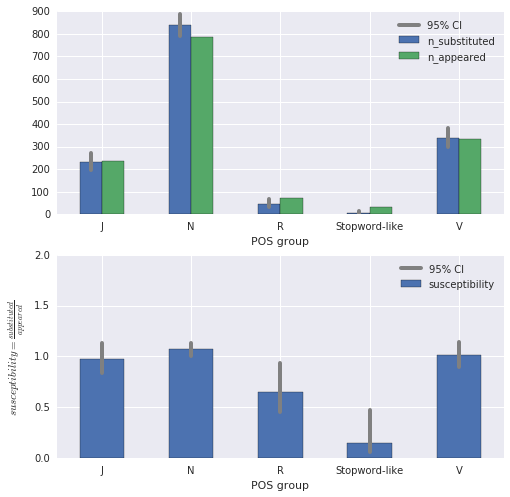

In [8]:
# Compute POS counts.
susties_pos = words[words.feature == 'aoa']\
    .groupby('rPOS')['target']\
    .aggregate({'susceptibility': susty_all,
                'n_substituted': target_all_counts,
                'n_appeared': appeared_all_counts})\
    .rename_axis('POS group')

# Plot.

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
# Raw substituted and appeared values.
susties_pos[['n_substituted', 'n_appeared']]\
    .plot(ax=axes[0], kind='bar', rot=0)
# With their CIs.
total_substituted = susties_pos.n_substituted.sum()
cis = multinomial_proportions_confint(susties_pos.n_substituted.round(),
                                      method='goodman')
for i in range(len(susties_pos)):
    axes[0].plot([i-.125, i-.125], cis[i] * total_substituted,
                 lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[0].legend()
# Substitutability values.
susties_pos['susceptibility']\
    .plot(ax=axes[1], kind='bar', legend=True, ylim=(0, 2), rot=0)
axes[1].set_ylabel(r'$susceptibility = \frac{substituted}{appeared}$')
# With their CIs.
for i in range(len(susties_pos)):
    axes[1].plot([i, i], (cis[i] * total_substituted 
                          / susties_pos.n_appeared.iloc[i]),
                 lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[1].legend(loc='best')
# Save if necessary.
if SAVE_FIGURES:
    fig.savefig(settings.FIGURE.format('all-susceptibilities-pos'),
                bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're in case (3) of the explanation below on confidence intervals (in section 3): it's really like a multinomial sampling, but not quite since not all POS tags are available to sample from in all the sentences. There's no way out of this, so we're going to use multinomial CIs. We can safely scale all the bars and CIs to their respective `n_appeared` values, since that is an independent given before the sampling.

**Are the appeared and substituted proportions statistically different?**

The only test we can easily do is a multinomial goodness-of-fit. This tells us if the `n_substituted` counts are significantly different from the reference `n_appeared` counts.

From there on we know a few things:
* Comparing a given POS's `n_substituted` count to its reference `n_appeared` count tells us if it's statistically different (< or >). We know this will be true individually for any POS that is out of its confidence region for the global goodness-of-fit test, since it's a weaker hypothesis (so the null rejection region will be wider, and the POS we're looking at is already in the rejection region for the global test). We don't know if it'll be true or not for POSes that are in their confidence region for the global test.
* Jointly comparing two POS's `n_substituted` counts to their reference `n_appeared` counts tells us if there is bias for one w.r.t. the other. This is also true for all pairs of POSes that are on alternate sides of their confidence region in the global test (for the same reasons as in the previous point). We don't know if it's true for the other POSes though.

In [9]:
# Test the n_substituted proportions are different from
# the n_appeared proportions
total_appeared = susties_pos.n_appeared.sum()
appeared_cis = multinomial_proportions_confint(
    susties_pos.n_appeared.round(), method='goodman')
differences = [(s < ci[0] * total_appeared) or (s > ci[1] * total_appeared)
               for s, ci in zip(susties_pos.n_substituted, appeared_cis)]
are_different = np.any(differences)
if are_different:
    print("Appeared and substituted proportions are different with p < .05")
    print("The following POS tags are out of their confidence region:",
          list(susties_pos.index[np.where(differences)[0]]))
else:
    print("Appeared and substituted proportions cannot be "
          "said different with p value better than .05")

Appeared and substituted proportions are different with p < .05
The following POS tags are out of their confidence region: ['N', 'R', 'Stopword-like']


## 3 On global feature values

Prepare plotting functions, for bin and quartile susceptibilities for each feature.

In [10]:
def print_significance(feature, h0s, heights):
    h0_total = h0s.sum()
    bin_count = len(h0s)
    print()
    print('-' * len(feature))
    print(feature)
    print('-' * len(feature))
    for n_stars, alpha in enumerate([.05, .01, .001]):
        h0_cis = multinomial_proportions_confint(h0s.round(),
                                                 method='goodman',
                                                 alpha=alpha)
        differences = ((heights < h0_cis[:, 0] * h0_total)
                       | (heights > h0_cis[:, 1] * h0_total))
        are_different = np.any(differences)
        stars = ' ' * (3 - n_stars) + '*' * (1 + n_stars)
        if are_different:
            bins_different = np.where(differences)[0]
            bins_different += np.ones_like(bins_different)
            print(stars + ' Target different H_0 with p < {}.'
                  ' Bins [1; {}] out of region: {}'
                  .format(alpha, bin_count, bins_different.tolist()))
        else:
            print('     Target NOT different from H_0 (p > {})'
                  .format(alpha))
            break

In [11]:
def plot_bin_susties(**kwargs):
    data = kwargs['data']
    feature = data.iloc[0].feature
    color = kwargs.get('color', 'blue')
    relative = kwargs.get('relative', False)
    quantiles = kwargs.get('quantiles', False)
    value = data.value_rel if relative else data.value
    
    # Compute binning.
    cut, cut_kws = ((pd.qcut, {}) if quantiles
                    else (pd.cut, {'right': False}))
    for bin_count in range(BIN_COUNT, 0, -1):
        try:
            value_bins, bins = cut(value, bin_count, labels=False,
                                   retbins=True, **cut_kws)
            break
        except ValueError:
            pass
    middles = (bins[:-1] + bins[1:]) / 2

    # Compute bin counts. Note here the bins are computed on the
    # distribution of observed substitutions, not the simulated aggregated
    # distributions of cluster-unit substitutions. But since it's mostly
    # deduplication that the aggregation process addresses, the bins
    # should be mostly the same. This could be corrected by computing
    # bins on the aggregate distribution (not hard), but it's really
    # not important now.
    heights = np.zeros(bin_count)
    h0s = np.zeros(bin_count)
    for i in range(bin_count):
        heights[i] = (data[data.target & (value_bins == i)]
                      .weight_feature.sum())
        h0s[i] = data[value_bins == i].weight_feature_appeared.sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = (r'\sigma_{\phi'
                + ('_r' if relative else '')
                + '}')
    plt.plot(middles, heights / h0s, 
             color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(middles, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(middles, np.ones_like(middles), '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xlim(middles[0], middles[-1])
    plt.ylim(0, 2)
    
    # Test for statistical significance
    print_significance(feature, h0s, heights)

In [12]:
def plot_grid(data, features, filename,
              plot_function, xlabel, ylabel, plot_kws={}):
    g = sb.FacetGrid(data=data[data['feature']
                               .map(lambda f: f in features)],
                     sharex=False, sharey=True,
                     col='feature', hue='feature',
                     col_order=features, hue_order=features,
                     col_wrap=3, aspect=1.5, size=3)
    g.map_dataframe(plot_function, **plot_kws)
    g.set_titles('{col_name}')
    g.set_xlabels(xlabel)
    g.set_ylabels(ylabel)
    for ax in g.axes.ravel():
        legend = ax.legend(frameon=True, loc='best')
        if not legend:
            # Skip if nothing was plotted on these axes.
            continue
        frame = legend.get_frame()
        frame.set_facecolor('#f2f2f2')
        frame.set_edgecolor('#000000')
        ax.set_title(Substitution._transformed_feature(ax.get_title())
                     .__doc__)
    if SAVE_FIGURES:
        g.fig.savefig(settings.FIGURE.format(filename),
                      bbox_inches='tight', dpi=300)

### 3.1 Bins of distribution of appeared global feature values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2]
     Target NOT different from H_0 (p > 0.001)



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.01)



-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.001)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [3]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


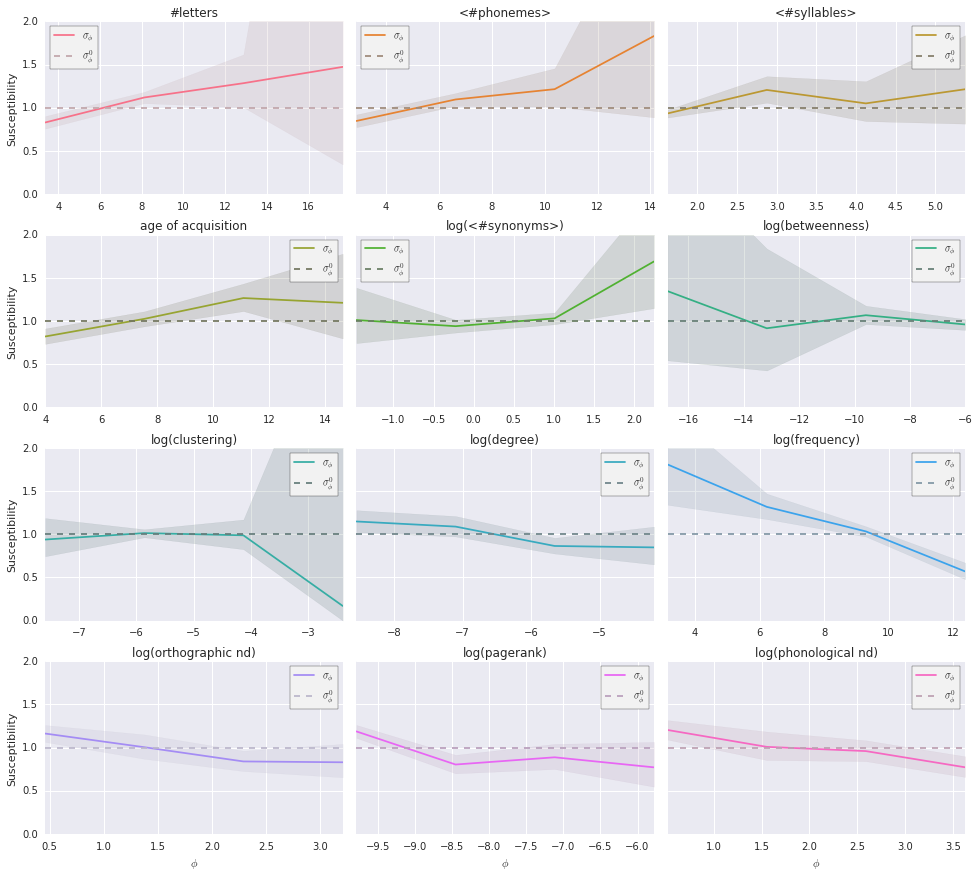

In [13]:
plot_grid(words, ordered_features,
          'all-susceptibilities-fixedbins_global',
          plot_bin_susties, r'$\phi$', 'Susceptibility')

**Note on how graphs and their confidence intervals are computed here**

There are three ways I can do a computation like above:

(1) For each word, we look at how many times it is substituted versus how many times it appears in a position where it could have been substituted. This is the *word*'s susceptibility, $\sigma(w)$. Then for each feature bin $b_i$ we take all the words such that $\phi(w) \in b_i$, average, and compute an asymptotic confidence interval based on how many words are in the bin. This fails for sentence-relative features, because a given word has different feature values depending on the sentence it appears in. So we discard this.

(2) Do the same but at the feature value level. So we define a *feature value* susceptibility, $\sigma_{\phi}(f)$, and compute a confidence interval based on how many different feature values we have in the bin. The idea behind (1) and (2) is to look at the bin middle-value like the relevant object we're measuring, and we have several measures for each bin middle-value, hence the confidence interval. In each bin $b_i$ we have:

$$\left< \sigma_{\phi}(f) \right>_{f \in b_i}$$

The problem with both (1) and (2) is that there's no proper $\mathcal{H}_0$ value, because the averages in the bins don't necessarily equal 1 under $\mathcal{H}_0$. Also, we can't check that there is consistency, showing that the sum of susceptibility values of the bins is 1. Hence case 3:

(3) Consider that we sample a multinomial process: each substitution is in fact the sampling of a feature value from one of the four bins. In that case, we can compute multinomial proportion CIs. This is also not completely satisfactory since in most cases not all feature values are available at the time of sampling, since most sentences don't range over all the feature's values, but it's what lets us compute proper null hypotheses: in each bin $b_i$ we have a value of $\sigma_{\phi}(b_i)$, and the sum of those should be the same under $\mathcal{H}_0$ as in the experiment (in practice in the graphs, we divide by the values under $\mathcal{H}_0$, and the reference is $\sigma_{\phi}^0(b_i) = 1$).

Here and below, we're always in case (3).


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.01)



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.01)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]


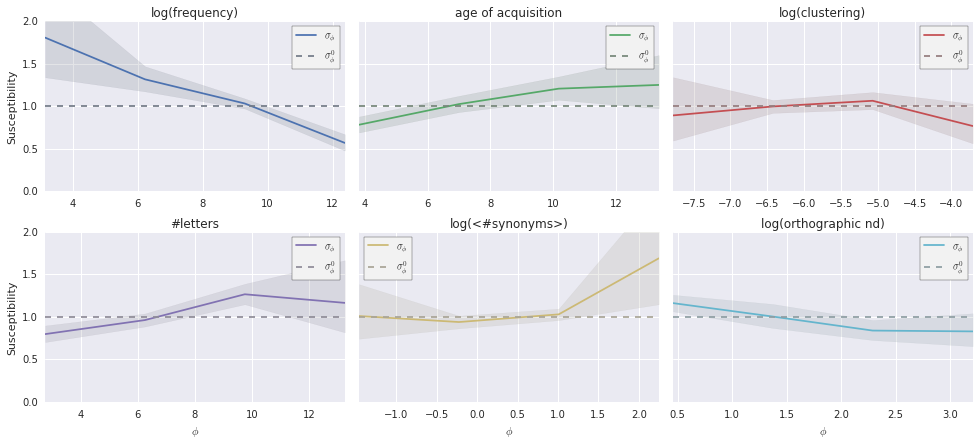

In [14]:
plot_grid(words[~(((words.feature == 'letters_count') 
                   & (words.value > 15))
                  | ((words.feature == 'aoa') 
                     & (words.value > 15))
                  | ((words.feature == 'clustering') 
                     & (words.value > -3)))],
          PAPER_FEATURES,
          'paper-susceptibilities-fixedbins_global',
          plot_bin_susties, r'$\phi$', 'Susceptibility')

### 3.2 Quantiles of distribution of appeared global feature values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 2] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 2] out of region: [1, 2]
 *** Target different H_0 with p < 0.001. Bins [1; 2] out of region: [1, 2]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.001)



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


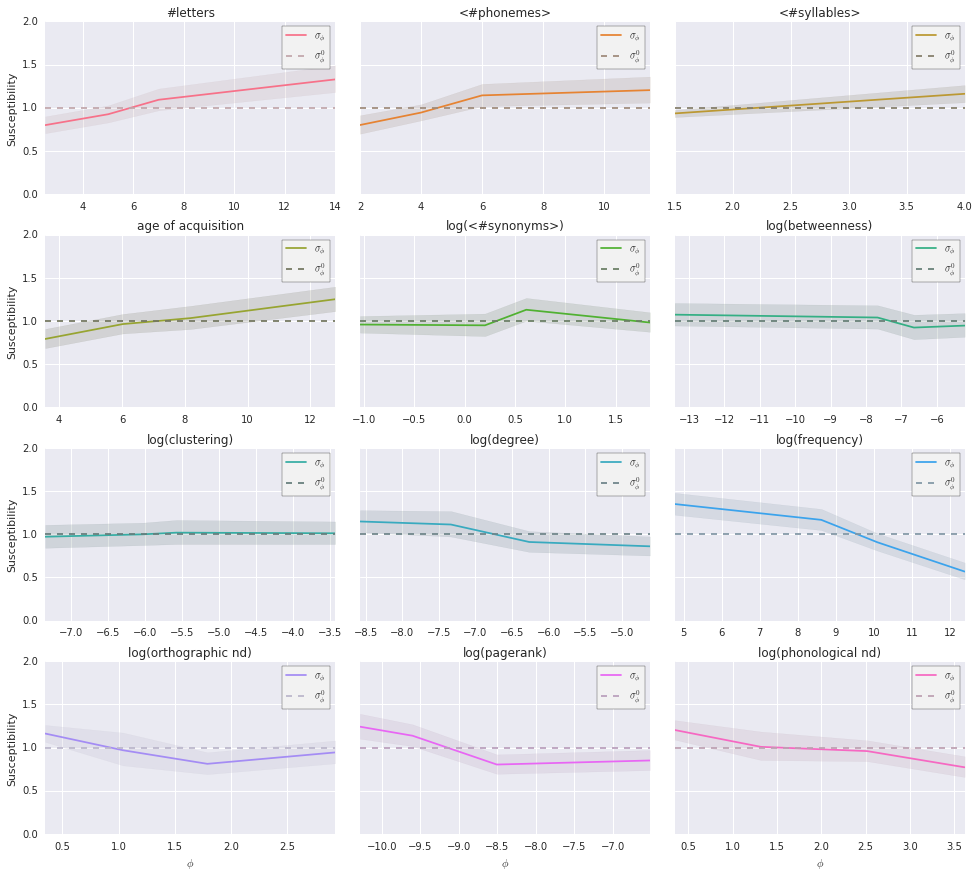

In [15]:
plot_grid(words, ordered_features,
          'all-susceptibilities-quantilebins_global', plot_bin_susties,
          r'$\phi$', 'Susceptibility',
          plot_kws={'quantiles': True})

**Note on confidence intervals**

Here we're again in case (2) of the above explanation on confidence intervals (in section 3.1), since we're just binning by quantiles instead of fixed-width bins.


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


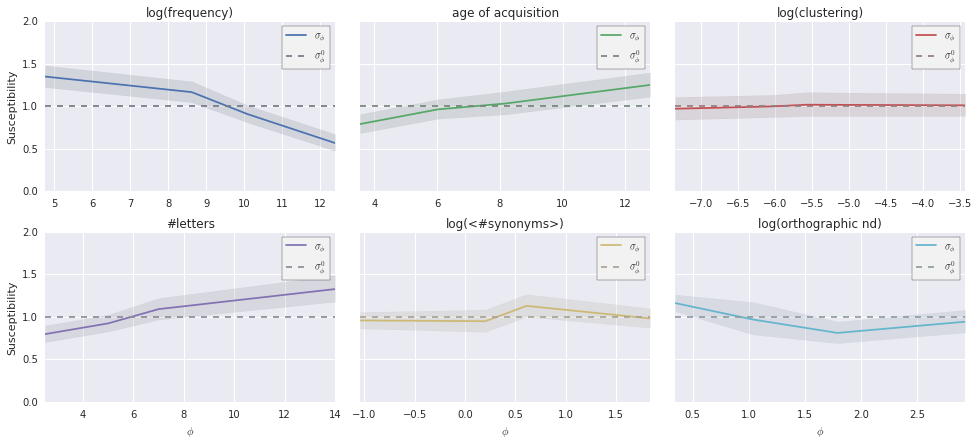

In [16]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-quantilebins_global', plot_bin_susties,
          r'$\phi$', 'Susceptibility',
          plot_kws={'quantiles': True})

## 4 On sentence-relative feature values

### 4.1 Bins of distribution of appeared sentence-relative values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3]
     Target NOT different from H_0 (p > 0.001)



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3, 4]
     Target NOT different from H_0 (p > 0.01)



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


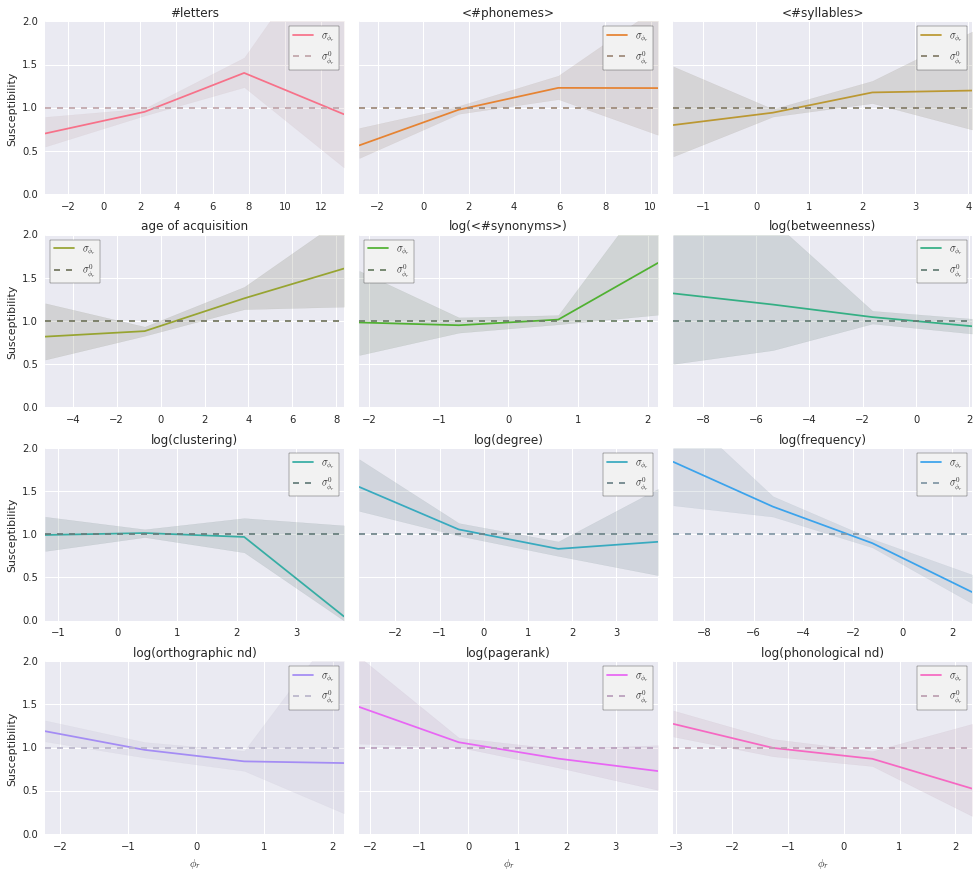

In [17]:
plot_grid(words, ordered_features,
          'all-susceptibilities-fixedbins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'relative': True})


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3]



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]


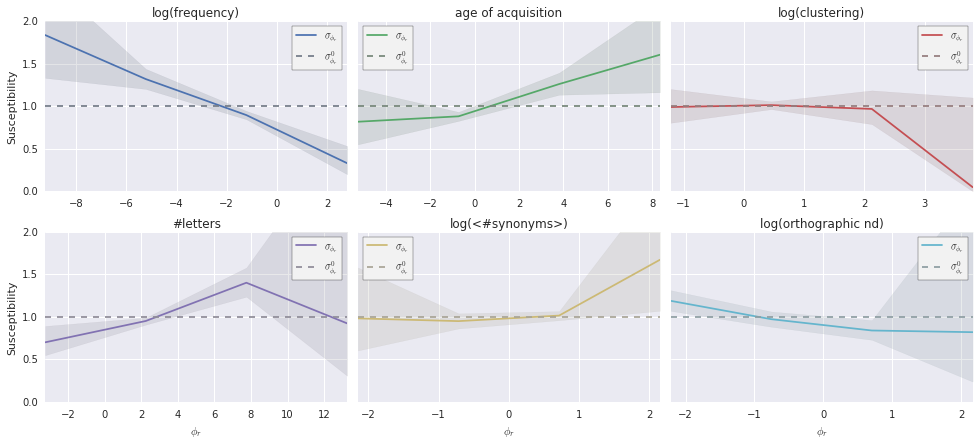

In [18]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-fixedbins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'relative': True})

### 4.2 Quantiles of distribution of appeared sentence-relative values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 3] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 3] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 3] out of region: [3]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
     Target NOT different from H_0 (p > 0.001)



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


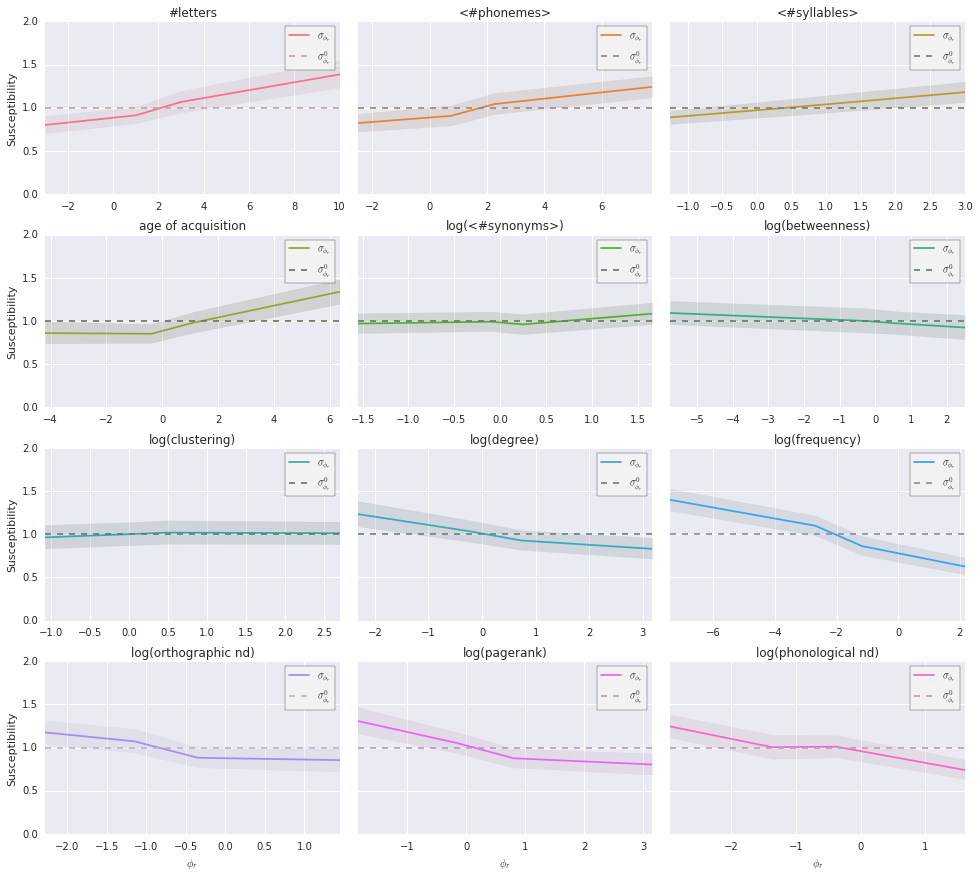

In [19]:
plot_grid(words, ordered_features,
          'all-susceptibilities-quantilebins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'quantiles': True, 'relative': True})


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
     Target NOT different from H_0 (p > 0.001)


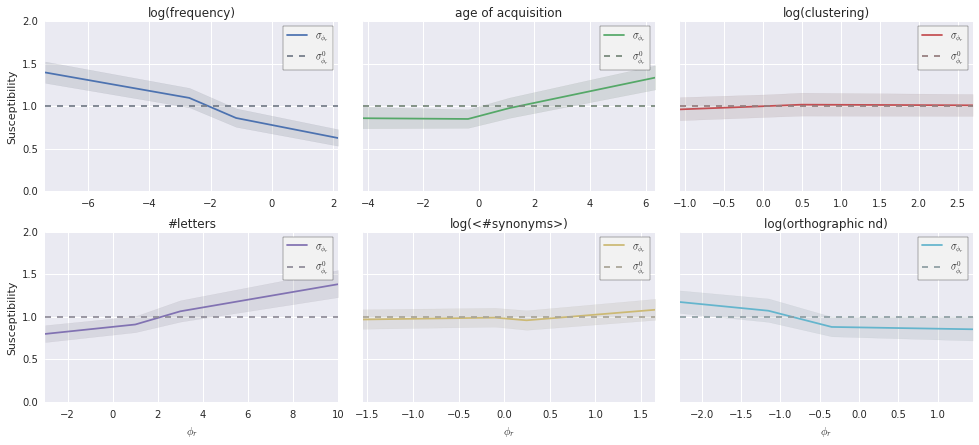

In [20]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-quantilebins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'quantiles': True, 'relative': True})

## 5 On quantiles and bins of the in-sentence distributions

### 5.1 In-sentence bins (of distribution of values in each sentence)

In [21]:
def plot_sentencebin_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    feature = data.iloc[0].feature
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    h0s = np.zeros(BIN_COUNT)
    for i in range(BIN_COUNT):
        heights[i] = (data[data.target & (data.bin == i)]
                      .weight_feature.sum())
        h0s[i] = data[data.bin == i].weight_feature_appeared.sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = r'\sigma_{bin_{\phi}}'
    x = range(1, BIN_COUNT + 1)
    plt.plot(x, heights / h0s, color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(x, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(x, np.ones_like(x), '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xticks(x)
    plt.ylim(0, None)
    
    # Test for significance.
    print_significance(feature, h0s, heights)


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



-----------
betweenness
-----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1]
     Target NOT different from H_0 (p > 0.01)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


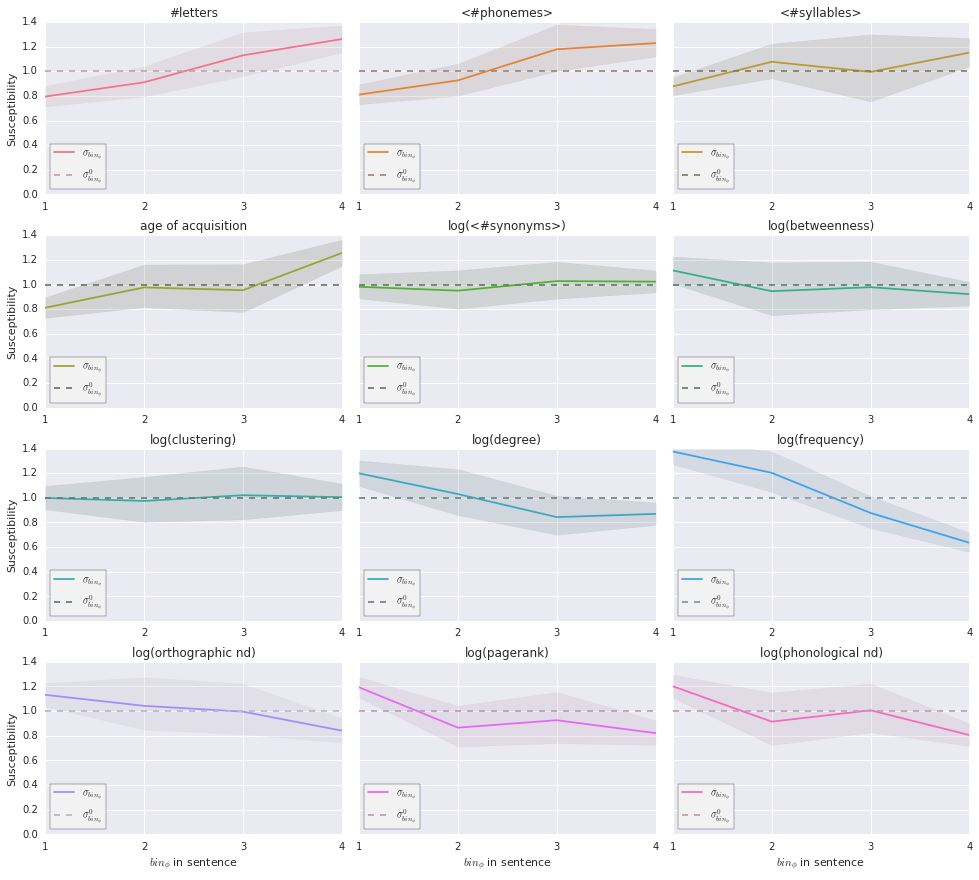

In [22]:
plot_grid(words, ordered_features,
          'all-susceptibilities-sentencebins',
          plot_sentencebin_susties, r'$bin_{\phi}$ in sentence',
          'Susceptibility')


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]


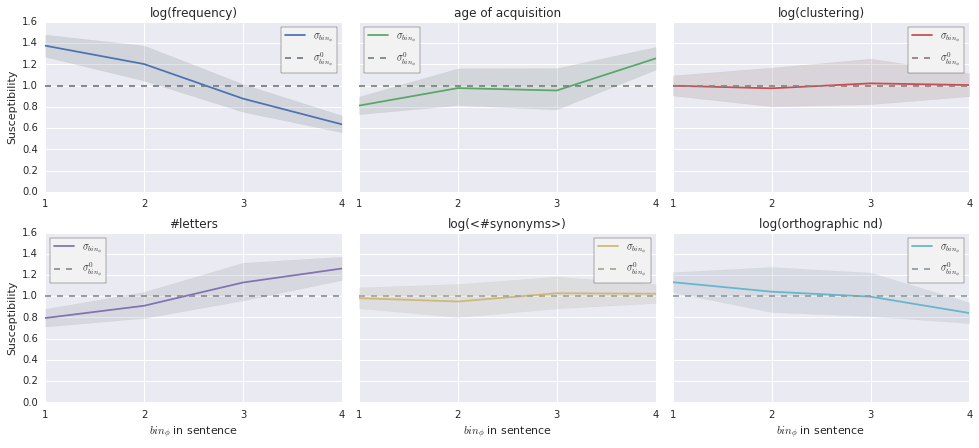

In [23]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-sentencebins',
          plot_sentencebin_susties, r'$bin_{\phi}$ in sentence',
          'Susceptibility')

### 5.2 In-sentence quantiles (of distribution of values in each sentence)

For each feature, count the sum of weights in each bin and plot that.

In [24]:
def bound(limits, values):
    left, right = limits
    assert left < right
    return np.maximum(left, np.minimum(right, values))

In [25]:
def plot_sentencequantile_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    feature = data.iloc[0].feature
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    h0s = np.zeros(BIN_COUNT)
    step = 1 / BIN_COUNT
    for i in range(BIN_COUNT):
        limits = [i * step, (i + 1) * step]
        contributions = ((bound(limits, data.stop_quantile)
                          - bound(limits, data.start_quantile))
                         / (data.stop_quantile - data.start_quantile))
        heights[i] = \
            (contributions * data.weight_feature)[data.target].sum()
        h0s[i] = (contributions * data.weight_feature_appeared).sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total)# / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = r'\sigma_{q_{\phi}}'
    x = range(1, BIN_COUNT + 1)
    plt.plot(x, heights,# / h0s,
             color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(x, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(x, h0s, '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xticks(x)
    plt.ylim(0, None)
    
    # Test for significance.
    print_significance(feature, h0s, heights)


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.001)



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


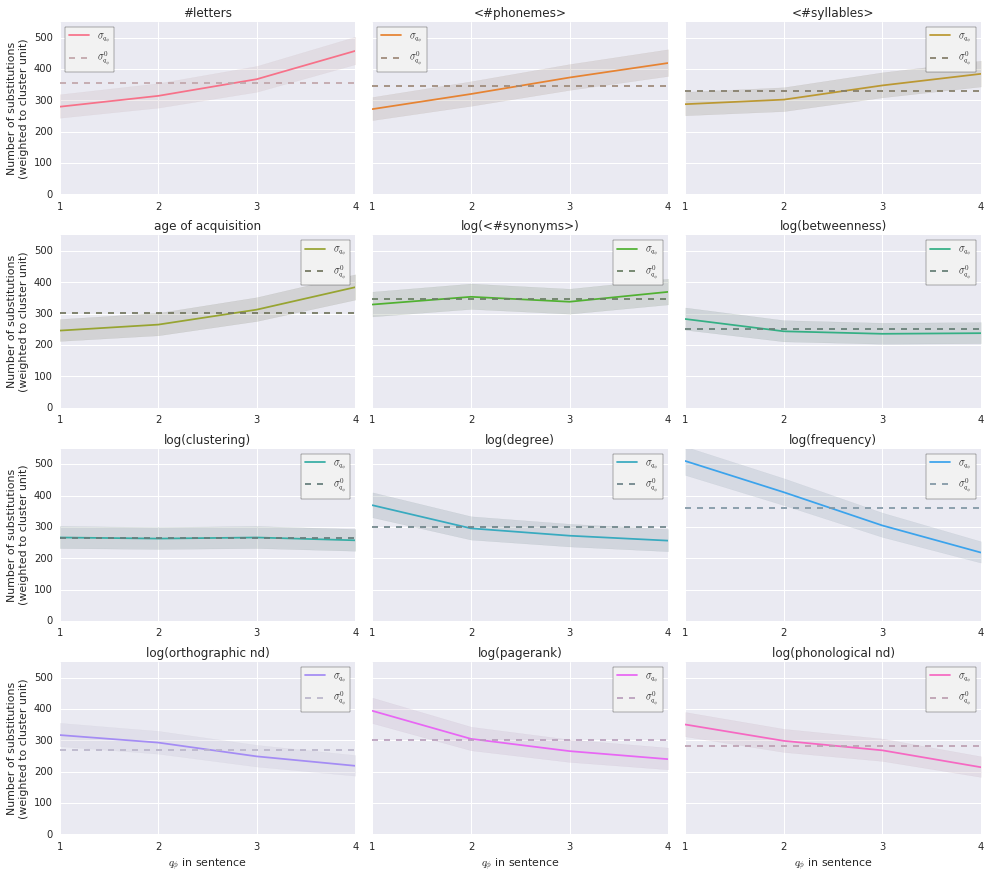

In [26]:
plot_grid(words, ordered_features,
          'all-susceptibilities-sentencequantiles',
          plot_sentencequantile_susties, r'$q_{\phi}$ in sentence',
          'Number of substitutions\n(weighted to cluster unit)')


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]


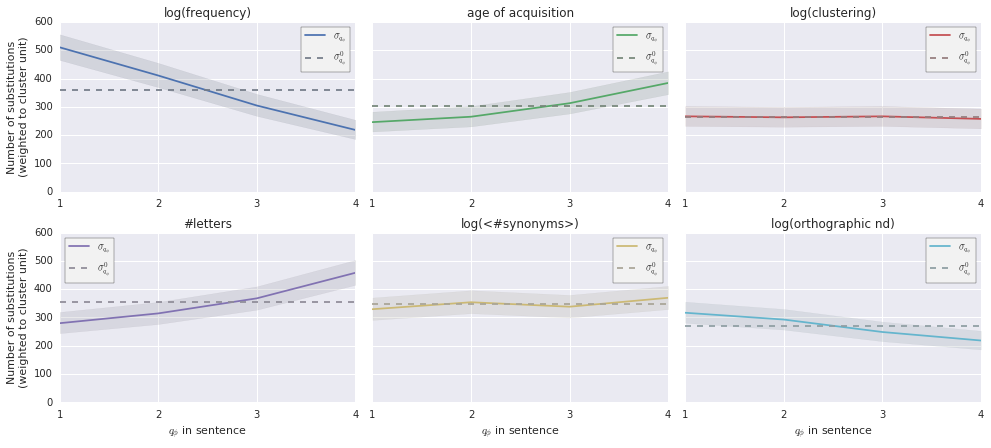

In [27]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-sentencequantiles',
          plot_sentencequantile_susties, r'$q_{\phi}$ in sentence',
          'Number of substitutions\n(weighted to cluster unit)')

## 6 Regression on significant features

### 6.1 Multinomial logistic regression

We try to predict which words are substituted, based on their global values, sentence-relative values, bins and quantiles of those, or in-sentence bin values.

Prediction is not good, mainly because the constraint of one-substitution-per-sentence can't be factored in the model simply. So precision is generally very low, around .20-.25, and when accuracy goes up recall plummets.

So it might show some interaction effects, but given that the fit is very bad I wouldn't trust it.

In-sentence quantiles (from section 5.2) were not done, as they're impossible to reduce to one value (our measure of those quantiles is in fact a subrange of [0, 1] for each word, corresponding to the subrange of the sentence distribution that that word's feature value represented).

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import binom_test

In [29]:
def regress_binning(data, features, value_funcs):
    # Compute bins
    data = data.copy()
    regress_features = [('{}'.format(value_name), feature)
                        for value_name in value_funcs.keys()
                        for feature in features]
    for i, (value_name, value_func) in enumerate(value_funcs.items()):
        data[value_name] = value_func(data)
    
    # Massage the dataframe to have feature bin as columns.
    data_wide = pd.pivot_table(
        data,
        values=list(value_funcs.keys()),
        index=['destination_id', 'occurrence', 'source_id', 'position',
               'word_position'],
        columns=['feature']
    )[regress_features]

    # Add the target value.
    # Question/FIXME: should we use weight_appeared for regression?
    data_wide['target'] = pd.pivot_table(
        data,
        values=['target'],
        index=['destination_id', 'occurrence', 'source_id', 'position',
               'word_position'],
        columns=['feature']
    )[('target', 'aoa')]
    data_wide = data_wide.dropna()

    # Compute polynomial features.
    poly = PolynomialFeatures(degree=2, interaction_only=True)
    pdata = poly.fit_transform(data_wide[regress_features])
    pregress_features = [' * '.join(['_'.join(regress_features[j])
                                   for j, p in enumerate(powers)
                                   if p > 0]) or 'intercept'
                         for powers in poly.powers_]

    # Divide into two sets.
    print('Regressing with {} word measures (divided into'
          ' training and prediction sets)'
          .format(len(data_wide)))
    pdata_train = pdata[:len(data_wide) // 2]
    target_train = data_wide.iloc[:len(data_wide) // 2].target
    pdata_predict = pdata[len(data_wide) // 2:]
    target_predict = data_wide.iloc[len(data_wide) // 2:].target
    assert len(pdata_train) + len(pdata_predict) == len(data_wide)
    assert len(target_train) + len(target_predict) == len(data_wide)
    
    # Regress
    regressor = LogisticRegression(penalty='l2', class_weight='balanced',
                                   fit_intercept=False)
    regressor.fit(pdata_train, target_train)
    
    # And predict
    prediction = regressor.predict(pdata_predict)
    standard = target_predict.values
    success = prediction == standard
    
    tp = prediction & standard
    tn = (~prediction) & (~standard)
    fp = prediction & (~standard)
    fn = (~prediction) & standard
    
    print()
    print('{:.2f}% of words well predicted (non-random at p = {:.1})'
          .format(100 * success.mean(),
                  binom_test(success.sum(), len(success))))
    print('Precision = {:.2f}'.format(standard[prediction].mean()))
    print('Recall = {:.2f}'.format(prediction[standard].mean()))
    print()
    print('Coefficients:')
    print(pd.Series(index=pregress_features, data=regressor.coef_[0]))

**Global feature value**

In [30]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'global': lambda d: d.value})

Regressing with 102853 word measures (divided into training and prediction sets)



60.44% of words well predicted (non-random at p = 1e-323)
Precision = 0.33
Recall = 0.65

Coefficients:
intercept                                             1.275558
global_frequency                                     -0.273638
global_aoa                                            0.040784
global_letters_count                                 -0.039877
global_orthographic_density                           0.073542
global_frequency * global_aoa                         0.009431
global_frequency * global_letters_count               0.002804
global_frequency * global_orthographic_density        0.021801
global_aoa * global_letters_count                     0.001123
global_aoa * global_orthographic_density             -0.050337
global_letters_count * global_orthographic_density    0.070326
dtype: float64


**Sentence-relative feature value**

In [31]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'sentence-rel': lambda d: d.value_rel})

Regressing with 102853 word measures (divided into training and prediction sets)



47.88% of words well predicted (non-random at p = 6e-22)
Precision = 0.23
Recall = 0.53

Coefficients:
intercept                                                        -0.359823
sentence-rel_frequency                                           -0.143639
sentence-rel_aoa                                                 -0.136237
sentence-rel_letters_count                                        0.192980
sentence-rel_orthographic_density                                 0.307976
sentence-rel_frequency * sentence-rel_aoa                        -0.020774
sentence-rel_frequency * sentence-rel_letters_count               0.045172
sentence-rel_frequency * sentence-rel_orthographic_density        0.106933
sentence-rel_aoa * sentence-rel_letters_count                     0.047767
sentence-rel_aoa * sentence-rel_orthographic_density              0.001625
sentence-rel_letters_count * sentence-rel_orthographic_density    0.064987
dtype: float64


**Global + sentence-relative feature values**

In [32]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'global': lambda d: d.value,
                 'sentence-rel': lambda d: d.value_rel})

Regressing with 102853 word measures (divided into training and prediction sets)



63.27% of words well predicted (non-random at p = 1e-323)
Precision = 0.36
Recall = 0.67

Coefficients:
intercept                                                         -3.599051
sentence-rel_frequency                                            -0.076445
sentence-rel_aoa                                                   0.418782
sentence-rel_letters_count                                         0.509561
sentence-rel_orthographic_density                                 -0.594045
global_frequency                                                   0.324873
global_aoa                                                        -0.432105
global_letters_count                                               0.624344
global_orthographic_density                                        1.345730
sentence-rel_frequency * sentence-rel_aoa                         -0.014016
sentence-rel_frequency * sentence-rel_letters_count                0.012362
sentence-rel_frequency * sentence-rel_orthographic_density 

**(3.1) Bins of distribution of appeared global feature values**

In [33]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'bins-global':
                     lambda d: pd.cut(d.value, BIN_COUNT,
                                      labels=False, right=False)})

Regressing with 102853 word measures (divided into training and prediction sets)



68.30% of words well predicted (non-random at p = 1e-323)
Precision = 0.40
Recall = 0.68

Coefficients:
intercept                                                      -0.681448
bins-global_frequency                                          -0.103274
bins-global_aoa                                                 1.987574
bins-global_letters_count                                      -1.122071
bins-global_orthographic_density                               -0.918661
bins-global_frequency * bins-global_aoa                        -0.329612
bins-global_frequency * bins-global_letters_count               0.275100
bins-global_frequency * bins-global_orthographic_density       -0.107479
bins-global_aoa * bins-global_letters_count                    -0.227617
bins-global_aoa * bins-global_orthographic_density             -0.043423
bins-global_letters_count * bins-global_orthographic_density    0.714058
dtype: float64


**(3.2) Quantiles of distribution of appeared global feature values**

In [34]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'quantiles-global':
                     lambda d: pd.qcut(d.value, BIN_COUNT, labels=False)})

Regressing with 102853 word measures (divided into training and prediction sets)



49.36% of words well predicted (non-random at p = 0.004)
Precision = 0.16
Recall = 0.26

Coefficients:
intercept                                                                 0.585522
quantiles-global_frequency                                               -2.268998
quantiles-global_aoa                                                      1.340849
quantiles-global_letters_count                                            3.492657
quantiles-global_orthographic_density                                    -3.988330
quantiles-global_frequency * quantiles-global_aoa                        -0.058907
quantiles-global_frequency * quantiles-global_letters_count              -0.354537
quantiles-global_frequency * quantiles-global_orthographic_density        2.177703
quantiles-global_aoa * quantiles-global_letters_count                    -0.441457
quantiles-global_aoa * quantiles-global_orthographic_density             -0.022311
quantiles-global_letters_count * quantiles-global_orthographic_den

**(4.1) Bins of distribution of appeared sentence-relative values**

In [35]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'bins-sentence-rel':
                     lambda d: pd.cut(d.value_rel, BIN_COUNT,
                                      labels=False, right=False)})

Regressing with 102853 word measures (divided into training and prediction sets)



71.66% of words well predicted (non-random at p = 1e-323)
Precision = 0.38
Recall = 0.32

Coefficients:
intercept                                                                   0.476710
bins-sentence-rel_frequency                                                -0.090673
bins-sentence-rel_aoa                                                      -0.130450
bins-sentence-rel_letters_count                                            -0.400449
bins-sentence-rel_orthographic_density                                      0.476710
bins-sentence-rel_frequency * bins-sentence-rel_aoa                        -0.618090
bins-sentence-rel_frequency * bins-sentence-rel_letters_count               0.211855
bins-sentence-rel_frequency * bins-sentence-rel_orthographic_density       -0.090673
bins-sentence-rel_aoa * bins-sentence-rel_letters_count                     0.585637
bins-sentence-rel_aoa * bins-sentence-rel_orthographic_density             -0.130450
bins-sentence-rel_letters_count * bins-senten

**(4.2) Quantiles of distribution of appeared sentence-relative values**

In [36]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'quantiles-sentence-rel':
                     lambda d: pd.qcut(d.value_rel, BIN_COUNT,
                                       labels=False)})

Regressing with 102853 word measures (divided into training and prediction sets)



49.52% of words well predicted (non-random at p = 0.03)
Precision = 0.28
Recall = 0.72

Coefficients:
intercept                                                                             0.963093
quantiles-sentence-rel_frequency                                                     -0.602735
quantiles-sentence-rel_aoa                                                           -0.301883
quantiles-sentence-rel_letters_count                                                 -0.404665
quantiles-sentence-rel_orthographic_density                                          -0.406860
quantiles-sentence-rel_frequency * quantiles-sentence-rel_aoa                         0.066774
quantiles-sentence-rel_frequency * quantiles-sentence-rel_letters_count              -0.009431
quantiles-sentence-rel_frequency * quantiles-sentence-rel_orthographic_density        0.262308
quantiles-sentence-rel_aoa * quantiles-sentence-rel_letters_count                     0.153722
quantiles-sentence-rel_aoa * quantiles-sen

**(5.1) In-sentence bins (of distribution of values in each sentence)**

In [37]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'in-sentence-bins': lambda d: d.bin})

Regressing with 102853 word measures (divided into training and prediction sets)



55.87% of words well predicted (non-random at p = 2e-156)
Precision = 0.30
Recall = 0.66

Coefficients:
intercept                                                                -0.175981
in-sentence-bins_frequency                                               -0.157765
in-sentence-bins_aoa                                                      0.174437
in-sentence-bins_letters_count                                            0.012879
in-sentence-bins_orthographic_density                                     0.067975
in-sentence-bins_frequency * in-sentence-bins_aoa                        -0.132150
in-sentence-bins_frequency * in-sentence-bins_letters_count              -0.014774
in-sentence-bins_frequency * in-sentence-bins_orthographic_density        0.065562
in-sentence-bins_aoa * in-sentence-bins_letters_count                     0.070887
in-sentence-bins_aoa * in-sentence-bins_orthographic_density              0.054929
in-sentence-bins_letters_count * in-sentence-bins_orthographic_de

### 6.2 PCA

We get coefficient values out of the PCA, but I can't figure what to make of them... They reflect the correlations of the features, alright, but beyond that? Some interactions, but there's no clear interpretation of the coefficients and variances explained into interaction strengths.

In [38]:
from sklearn.decomposition import PCA

In [39]:
def pca_values(data, features, value_func):
    data = data.copy()
    data['pca_value'] = value_func(data)
    
    # Prepare dataframe, averaging over shared durl.
    data_wide = pd.pivot_table(
        data[data.target],
        values='pca_value',
        index=['cluster_id', 'destination_id', 'occurrence',
               'position'],
        columns=['feature']
    )[features]
    # ... then over shared clusters, and dropping NaNs.
    data_wide = data_wide\
        .groupby(level='cluster_id')\
        .agg(np.mean)\
        .dropna(how='any')
    print('Computing PCA on {} aggregated word measures'
          .format(len(data_wide)))
    print()
    
    # Compute PCA.
    pca = PCA(n_components='mle')
    pca.fit(data_wide)
    print('Variance explained by first {} components (mle-estimated): {}'
          .format(pca.n_components_, pca.explained_variance_ratio_))
    print()
    print('Components:')
    print(pd.DataFrame(index=data_wide.columns,
                       data=pca.components_.T,
                       columns=['Comp. {}'.format(i)
                                for i in range(pca.n_components_)]))

**PCA of feature value of substituted words**

In [40]:
pca_values(words, ['frequency', 'aoa', 'letters_count'],
           lambda d: d.value)

Computing PCA on 1190 aggregated word measures



Variance explained by first 2 components (mle-estimated): [ 0.67796677  0.19210051]

Components:
                Comp. 0   Comp. 1
feature                          
frequency     -0.372530  0.510251
aoa            0.741134 -0.339123
letters_count  0.558517  0.790342


**PCA of sentence-relative value of substituted words**

In [41]:
pca_values(words, ['frequency', 'aoa', 'letters_count'],
           lambda d: d.value_rel)

Computing PCA on 1190 aggregated word measures

Variance explained by first 2 components (mle-estimated): [ 0.6351579   0.20777689]

Components:
                Comp. 0   Comp. 1
feature                          
frequency     -0.484267  0.455808
aoa            0.682869 -0.336715
letters_count  0.546969  0.823931
